<a href="https://colab.research.google.com/github/AbhigyanSingh97/Loan-defaulters-prediction/blob/master/Loan_defaulters_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import  datetime
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [0]:
data = pd.read_csv('/content/drive/My Drive/data/XYZCorp_LendingData.csv')

In [0]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 476.73 MB --> 288.16 MB (Decreased by 39.6%)


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           855969 non-null  int32  
 1   member_id                    855969 non-null  int32  
 2   loan_amnt                    855969 non-null  int32  
 3   funded_amnt                  855969 non-null  int32  
 4   funded_amnt_inv              855969 non-null  float32
 5   term                         855969 non-null  object 
 6   int_rate                     855969 non-null  float32
 7   installment                  855969 non-null  float32
 8   grade                        855969 non-null  object 
 9   sub_grade                    855969 non-null  object 
 10  emp_title                    806526 non-null  object 
 11  emp_length                   812908 non-null  object 
 12  home_ownership               855969 non-null  object 
 13 

In [0]:
def check_missing_data(df):
    flag=df.isna().sum().any()
    if flag==True:
        total = df.isnull().sum()
        percent = ((df.isnull().sum())/len(df))*100
        output = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        data_type = []
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [0]:
check_missing_data(data)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
Total,0,0,0,0,0,0,0,0,0,0,49443,43061,0,0,0,0,0,734157,0,33,0,0,0,0,0,0,439812,724785,0,0,0,446,0,0,0,0,0,0,0,0,0,0,0,8862,0,252971,50,56,642830,0,0,855527,855529,855527,0,67313,67313,842681,842681,842681,842681,843035,842681,844360,842681,842681,842681,842681,67313,842681,842681,842681,0
Percent,0,0,0,0,0,0,0,0,0,0,5.77626,5.03067,0,0,0,0,0,85.7691,0,0.00385528,0,0,0,0,0,0,51.3818,84.6742,0,0,0,0.0521047,0,0,0,0,0,0,0,0,0,0,0,1.03532,0,29.5538,0.00584133,0.00654229,75.0997,0,0,99.9484,99.9486,99.9484,0,7.86395,7.86395,98.4476,98.4476,98.4476,98.4476,98.489,98.4476,98.6438,98.4476,98.4476,98.4476,98.4476,7.86395,98.4476,98.4476,98.4476,0
Types,int32,int32,int32,int32,float32,object,float32,float32,object,object,object,object,object,float32,object,object,object,object,object,object,object,object,float32,int8,object,int8,float32,float32,int8,int8,int32,float32,int16,object,float32,float32,float32,float32,float32,float32,float32,float32,float32,object,float32,object,object,float32,float32,int8,object,float32,float32,object,int8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int8


In [0]:
data1 = data.copy()

In [0]:
pd.set_option('display.max_columns',None)

In [0]:
data1.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.869995,B,B2,NaN,10+ years,RENT,24000.0,Verified,01-12-2011,n,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,01-01-1985,1,NaN,NaN,3,0,13648,83.699997,9,f,0.0,0.0,5861.071289,5831.779785,5000.000000,861.070007,0.0,0.000000,0.00,01-01-2015,171.619995,NaN,01-01-2016,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.830002,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,01-12-2011,n,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,01-04-1999,5,NaN,NaN,3,0,1687,9.400000,4,f,0.0,0.0,1008.710022,1008.710022,456.459991,435.170013,0.0,117.080002,1.11,01-04-2013,119.660004,NaN,01-09-2013,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,01-12-2011,n,NaN,small_business,real estate business,606xx,IL,8.72,0,01-11-2001,2,NaN,NaN,2,0,2956,98.500000,10,f,0.0,0.0,3003.653564,3003.649902,2400.000000,603.650024,0.0,0.000000,0.00,01-06-2014,649.909973,NaN,01-01-2016,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [0]:
data1['emp_length'].replace(to_replace = '10+ years',value = 10,inplace = True)
data1['emp_length'].replace(to_replace = '9 years',value = 9,inplace = True)
data1['emp_length'].replace(to_replace = '8 years',value = 8,inplace = True)
data1['emp_length'].replace(to_replace = '7 years',value = 7,inplace = True)
data1['emp_length'].replace(to_replace = '6 years',value = 6,inplace = True)
data1['emp_length'].replace(to_replace = '5 years',value = 5,inplace = True)
data1['emp_length'].replace(to_replace = '4 years',value = 4,inplace = True)
data1['emp_length'].replace(to_replace = '3 years',value = 3,inplace = True)
data1['emp_length'].replace(to_replace = '2 years',value = 2,inplace = True)
data1['emp_length'].replace(to_replace = '1 year',value = 1,inplace = True)
data1['emp_length'].replace(to_replace = '< 1 year',value = 0,inplace = True)

In [0]:
data1['issue_d'] = pd.to_datetime(data1['issue_d'],dayfirst=True)
data1['earliest_cr_line'] = pd.to_datetime(data1['earliest_cr_line'],dayfirst=True)
data1['last_pymnt_d'] = pd.to_datetime(data1['last_pymnt_d'],dayfirst=True)
data1['next_pymnt_d'] = pd.to_datetime(data1['next_pymnt_d'],dayfirst=True)
data1['last_credit_pull_d'] = pd.to_datetime(data1['last_credit_pull_d'],dayfirst=True)

In [0]:
data1['issue_year'] = pd.DatetimeIndex(data1['issue_d']).year.astype(object)
data1['issue_month'] = pd.DatetimeIndex(data1['issue_d']).month.astype(object)
data1['issue_day'] =  pd.DatetimeIndex(data1['issue_d']).day


data1['earliest_cr_line_year'] = pd.DatetimeIndex(data1['earliest_cr_line']).year.astype(object)
data1['earliest_cr_line_month'] = pd.DatetimeIndex(data1['earliest_cr_line']).month.astype(object)
data1['earliest_cr_line_day'] =  pd.DatetimeIndex(data1['earliest_cr_line']).day

data1['last_pymnt_year'] = pd.DatetimeIndex(data1['last_pymnt_d']).year.astype(object)
data1['last_pymnt_month'] = pd.DatetimeIndex(data1['last_pymnt_d']).month.astype(object)
data1['last_pymnt_day'] =  pd.DatetimeIndex(data1['last_pymnt_d']).day

data1['next_pymnt_year'] = pd.DatetimeIndex(data1['next_pymnt_d']).year.astype(object)
data1['next_pymnt_month'] = pd.DatetimeIndex(data1['next_pymnt_d']).month.astype(object)
data1['next_pymnt_day'] =  pd.DatetimeIndex(data1['next_pymnt_d']).day

data1['last_credit_pull_year'] = pd.DatetimeIndex(data1['last_credit_pull_d']).year.astype(object)
data1['last_credit_pull_month'] = pd.DatetimeIndex(data1['last_credit_pull_d']).month.astype(object)
data1['last_credit_pull_day'] =  pd.DatetimeIndex(data1['last_credit_pull_d']).day

In [0]:
print(data1['issue_month'].value_counts())
print( )
print(data1['earliest_cr_line_month'].value_counts())
print( )
print(data1['next_pymnt_month'].value_counts())
print( )
print(data1['last_pymnt_month'].value_counts())
print( )
print(data1['last_credit_pull_month'].value_counts())

10    109565
7      92928
11     86141
8      74796
12     70584
4      68057
5      65934
6      61874
9      60808
1      60763
3      54297
2      50222
Name: issue_month, dtype: int64

8     83420
9     83368
10    83059
11    75690
12    69974
3     69252
7     68901
5     66402
6     65903
4     64180
1     63793
2     62027
Name: earliest_cr_line_month, dtype: int64

2.0    534094
1.0     68838
3.0        66
Name: next_pymnt_month, dtype: int64

1.0     482152
12.0    155140
10.0     24986
7.0      24721
8.0      23548
9.0      22004
11.0     21400
6.0      20935
5.0      19314
3.0      18921
4.0      18694
2.0      15292
Name: last_pymnt_month, dtype: int64

1.0     709200
12.0     25079
11.0     16813
10.0     15672
9.0      14742
7.0      13016
8.0      12624
6.0      10758
5.0       9775
4.0       9657
3.0       9644
2.0       8939
Name: last_credit_pull_month, dtype: int64


Since month of all these have same value we will drop this later on will dropping the unwanted columns.


In [0]:
data1.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind,issue_year,issue_month,issue_day,earliest_cr_line_year,earliest_cr_line_month,earliest_cr_line_day,last_pymnt_year,last_pymnt_month,last_pymnt_day,next_pymnt_year,next_pymnt_month,next_pymnt_day,last_credit_pull_year,last_credit_pull_month,last_credit_pull_day
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.869995,B,B2,NaN,10.0,RENT,24000.0,Verified,2011-12-01,n,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,1985-01-01,1,NaN,NaN,3,0,13648,83.699997,9,f,0.0,0.0,5861.071289,5831.779785,5000.000000,861.070007,0.0,0.000000,0.00,2015-01-01,171.619995,NaT,2016-01-01,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2011,12,1,1985,1,1,2015,1,1.0,NaN,NaN,NaN,2016,1,1.0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.830002,C,C4,Ryder,0.0,RENT,30000.0,Source Verified,2011-12-01,n,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,1999-04-01,5,NaN,NaN,3,0,1687,9.400000,4,f,0.0,0.0,1008.710022,1008.710022,456.459991,435.170013,0.0,117.080002,1.11,2013-04-01,119.660004,NaT,2013-09-01,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2011,12,1,1999,4,1,2013,4,1.0,NaN,NaN,NaN,2013,9,1.0
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.330002,C,C5,NaN,10.0,RENT,12252.0,Not Verified,2011-12-01,n,NaN,small_business,real estate business,606xx,IL,8.72,0,2001-11-01,2,NaN,NaN,2,0,2956,98.500000,10,f,0.0,0.0,3003.653564,3003.649902,2400.000000,603.650024,0.0,0.000000,0.00,2014-06-01,649.909973,NaT,2016-01-01,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,2011,12,1,2001,11,1,2014,6,1.0,NaN,NaN,NaN,2016,1,1.0


# Visualising data

In [0]:
data1['emp_length'] = data1['emp_length'].astype(object)

In [0]:
data1['emp_length'].dtypes

dtype('O')

In [0]:
data_num = data1.select_dtypes(exclude = object)

In [0]:
data_num.drop(['id','member_id'],axis=1,inplace=True)

In [0]:
cols = data_num.drop('default_ind',axis=1).columns
cols.nunique()

59

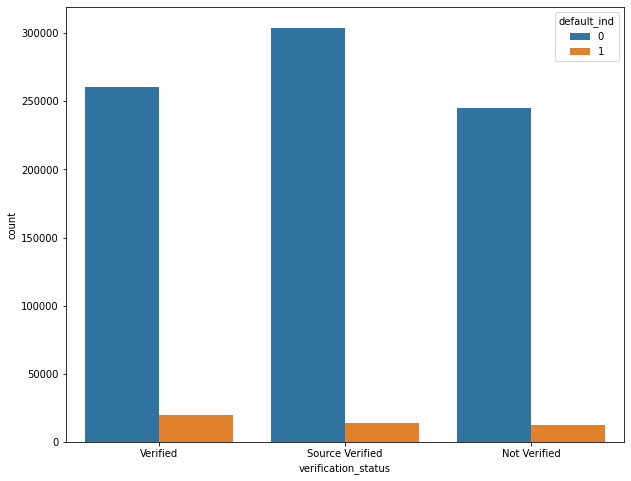

In [0]:
plt.figure(figsize=(10,8))
sns.countplot(data1['verification_status'],hue=data1['default_ind'])

## Let's see how many wanted loan for what.

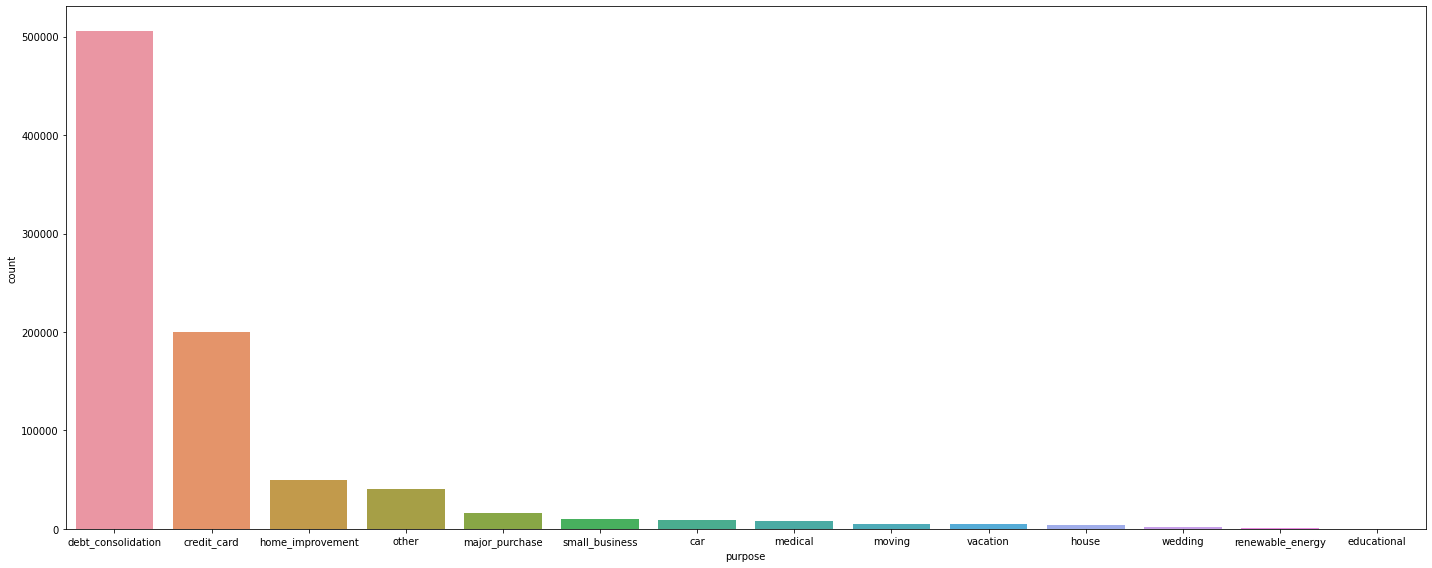

In [0]:
plt.figure(figsize=(20,8))
sns.countplot(data1['purpose'],order=data1['purpose'].value_counts().index)
plt.tight_layout()

Surprisingly Educational loan were too low,mostly loans were taken to pay back other debt and credit card bills.

## Let's see if people applying for loan had their own home or not.

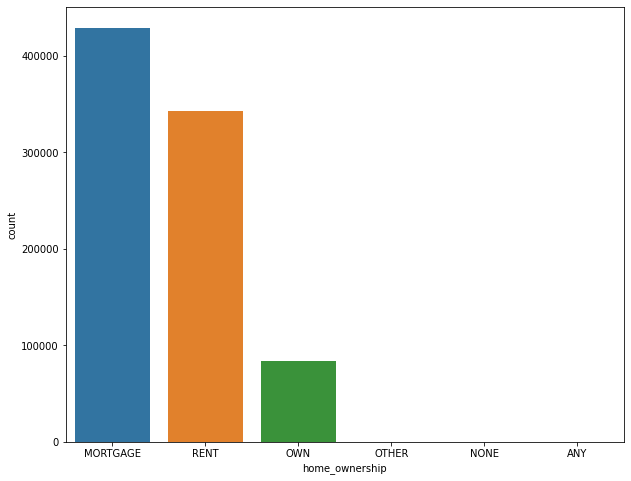

In [0]:
plt.figure(figsize=(10,8))
sns.countplot(data1['home_ownership'],order = data1['home_ownership'].value_counts().index)

High amount of people gave their home as a mortgage to the bank and others applying were in a rented home and very few had their own home.

# correlation between variables

In [0]:
data_num.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind,issue_day,earliest_cr_line_day,last_pymnt_day,next_pymnt_day,last_credit_pull_day
count,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,8.559690e+05,855969.000000,855969.000000,855969.000000,416157.000000,131184.000000,855969.000000,855969.000000,8.559690e+05,855523.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855969.000000,855913.000000,213139.000000,855969.0,442.000000,440.000000,855969.000000,7.886560e+05,7.886560e+05,13288.000000,13288.000000,13288.000000,13288.000000,12934.000000,13288.000000,11609.000000,13288.000000,13288.000000,13288.000000,13288.000000,7.886560e+05,13288.000000,13288.000000,13288.000000,855969.000000,855969.0,855969.0,847107.0,602998.0,855919.0
mean,14745.571335,14732.378305,14723.710938,13.189916,436.212067,7.510373e+04,18.122236,0.311621,0.680915,34.149944,70.463959,11.542447,0.194537,1.691053e+04,55.019497,25.269269,8284.542969,8281.175781,7653.950684,7622.844238,5851.820801,1754.927124,0.319529,47.089603,4.951231,2226.285400,0.014230,44.101452,1.0,107412.156250,18.318476,0.004944,2.254082e+02,1.397676e+05,1.072998,2.945665,0.749323,1.666767,20.833153,36511.609375,71.486908,1.354305,2.945515,5840.448730,61.024471,3.216146e+04,0.947772,1.524232,1.841963,0.054286,1.0,1.0,1.0,1.0,1.0
std,8425.340005,8419.471653,8429.149414,4.366093,243.668320,6.425615e+04,17.419512,0.857189,0.964033,21.868347,27.826330,5.308094,0.581585,2.222374e+04,23.806990,11.818841,8457.854492,8455.100586,7908.611328,7884.908691,6673.848633,2081.329590,3.596206,411.174133,62.294647,4865.778809,0.133305,22.165277,0.0,47987.617188,7.221854,0.077333,1.048748e+04,1.539199e+05,1.206898,3.080292,0.986167,1.685390,26.738926,42492.796875,23.015284,1.483668,2.595248,5108.491699,20.018181,3.769116e+04,1.441681,2.697535,2.975011,0.226581,0.0,0.0,0.0,0.0,0.0
min,500.000000,500.000000,0.000000,5.320000,15.690000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,17950.000000,3.050000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000,0.000000,1.0,1.0,1.0,1.0,1.0
25%,8000.000000,8000.000000,8000.000000,9.990000,260.549988,4.500000e+04,11.880000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,6.469000e+03,37.599998,17.000000,0.000000,0.000000,1969.689941,1960.119995,1239.949951,451.269989,0.000000,0.000000,0.000000,285.420013,0.000000,27.000000,1.0,75000.250000,13.187500,0.000000,0.000000e+00,2.987000e+04,0.000000,1.000000,0.000000,0.000000,6.000000,10390.250000,58.500000,0.000000,1.000000,2405.000000,47.900002,1.400000e+04,0.000000,0.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0
50%,13000.000000,13000.000000,13000.000000,12.990000,382.549988,6.500000e+04,17.610001,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,1.190300e+04,55.900002,24.000000,6290.250000,6287.649902,4976.160156,4948.250000,3286.889893,1076.910034,0.000000,0.000000,0.000000,468.820007,0.000000,44.000000,1.0,100000.000000,17.735001,0.000000,0.000000e+00,8.100850e+04,1.000000,2.000000,0.000000,1

As the mean and the median(50%) of the numerical features of the data are mostly close to each other,it shows that the data is somewhat normally distributed.

In [0]:
data_num.corr('spearman')

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind,issue_day,earliest_cr_line_day,last_pymnt_day,next_pymnt_day,last_credit_pull_day
loan_amnt,1.000000,0.999382,0.997113,0.114490,0.960242,0.503831,0.055750,0.008002,-0.039640,-0.038328,0.015297,0.216130,-0.112762,0.501730,0.121585,0.237571,0.515491,0.515479,0.427287,0.428346,0.331400,0.560034,-0.015528,0.000852,-0.000951,0.589121,-0.018337,-0.031215,NaN,0.497825,0.030982,0.003544,-0.078965,0.354133,-0.038391,0.065412,-0.015789,0.031382,0.018654,0.148682,-0.136075,-0.053988,-0.033086,0.429670,-0.011091,0.463545,0.015592,0.078820,0.003822,-0.005065,NaN,NaN,NaN,NaN,NaN
funded_amnt,0.999382,1.000000,0.997900,0.114852,0.961213,0.503550,0.056506,0.008326,-0.039938,-0.038367,0.015043,0.216543,-0.112360,0.501619,0.122050,0.237497,0.517379,0.517366,0.426174,0.427454,0.330243,0.559441,-0.015955,0.000073,-0.001577,0.589023,-0.018175,-0.031213,NaN,0.497825,0.030982,0.003643,-0.078965,0.354132,-0.038391,0.065412,-0.015789,0.031382,0.018654,0.148682,-0.136075,-0.053988,-0.033086,0.429670,-0.011091,0.463544,0.015592,0.078820,0.003822,-0.005824,NaN,NaN,NaN,NaN,NaN
funded_amnt_inv,0.997113,0.997900,1.000000,0.114856,0.958733,0.502538,0.058721,0.008998,-0.040915,-0.036744,0.024361,0.217477,-0.110837,0.500757,0.122517,0.237854,0.522106,0.522109,0.421114,0.425820,0.325315,0.555779,-0.018495,-0.002608,-0.004174,0.586723,-0.017714,-0.030985,NaN,0.499120,0.028808,0.003862,-0.078946,0.354127,-0.038779,0.064941,-0.016493,0.030633,0.019339,0.148091,-0.136633,-0.054200,-0.033299,0.430026,-0.012015,0.463663,0.015209,0.078845,0.003425,-0.008817,NaN,NaN,NaN,NaN,NaN
int_rate,0.114490,0.114852,0.114856,1.000000,0.109546,-0.124160,0.164491,0.065817,0.228297,-0.031284,0.018187,-0.015343,0.069320,-0.030948,0.279749,-0.051910,-0.013077,-0.013170,0.152297,0.153589,0.023785,0.422789,0.049450,0.113504,0.112223,0.099485,0.014247,-0.011563,NaN,-0.067894,0.267412,0.027300,0.031690,-0.094461,0.206481,0.059057,0.233524,0.184918,-0.211572,0.079796,0.204929,0.154280,0.159668,-0.136608,0.317429,-0.236224,0.157016,0.012782,0.259818,0.149864,NaN,NaN,NaN,NaN,NaN
installment,0.960242,0.961213,0.958733,0.109546,1.000000,0.483529,0.048224,0.015208,-0.013837,-0.041304,0.012947,0.204290,-0.104777,0.482381,0.138192,0.216037,0.443130,0.443116,0.472379,0.473331,0.394767,0.553631,-0.010091,0.008574,0.007447,0.629930,-0.016561,-0.033624,NaN,0.473761,0.028643,0.005389,-0.072990,0.316699,-0.025798,0.048612,-0.007974,0.023820,0.015014,0.129327,-0.127988,-0.033426,-0.013678,0.407187,-0.002713,0.429227,0.014424,0.062424,0.019057,0.005443,NaN,NaN,NaN,NaN,NaN
annual_inc,0.503831,0.503550,0.502538,-0.124160,0.483529,1.000000,-0.211412,0.087625,0.040445,-0.082116,-0.094716,0.243333,-0.052012,0.411157,0.072974,0.328770,0.249546,0.249571,0.220211,0.220644,0.199264,0.204983,-0.011001,-0.036006,-0.035549,0.332766,-0.004761,-0.060741,NaN,0.619723,-0.029673,0.022403,-0.036813,0.533187,0.042793,0.182218,0.107330,0.172834,-0.108219,0.322574,-0.113630,-0.020841,-0.021032,0.363579,0.006711,0.409336,0.094992,0.111519,0.089863,-0.059812,NaN,NaN,NaN,NaN,NaN
dti,0.055750,0.056506,0.058721,0.164491,0.048224,-0.211412,1.000000,-0.009825,-0.006056,0.001723,0.063410,0.322318,-0.050740,0.247968,0.168526,0.236381,0.129421,0.129375,-0.082802,-0.080468,-0.114612,0.031060,-0.013768,-0.006137,-0.005306,-0.035925,-0.000516,0.028362,NaN,-0.138116,0.569900,0.00

### Let's check if annual income is correlated with loan amount issued.

In [0]:
data_num[['annual_inc','loan_amnt']].corr('spearman')

,annual_inc,loan_amnt
annual_inc,1.000000,0.503831
loan_amnt,0.503831,1.000000


In [0]:
data_num[data_num['default_ind']==1][['annual_inc','loan_amnt']].corr(method='spearman')

,annual_inc,loan_amnt
annual_inc,1.000000,0.538333
loan_amnt,0.538333,1.000000


there's a little positive correlation between the variables for the people who defaulted.

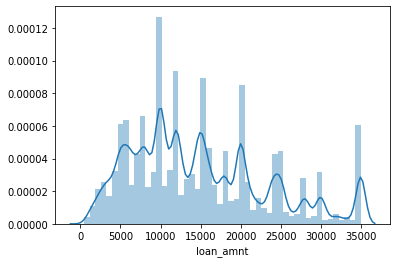

In [0]:
sns.distplot(data_num['loan_amnt'],hist = True)

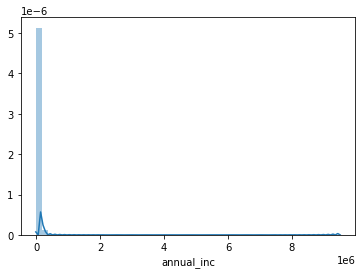

In [0]:
sns.distplot(data_num['annual_inc'],hist = True)

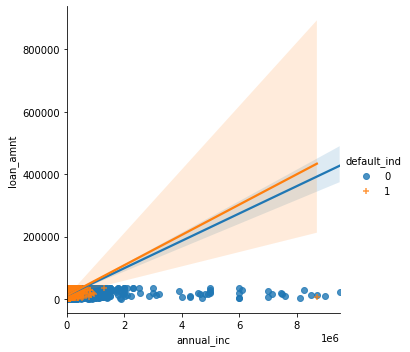

In [0]:
sns.lmplot('annual_inc','loan_amnt',data_num,fit_reg = True,hue='default_ind',markers=['o','+'])

But when plotting the regression plot it can be seen it is hardly correlated.

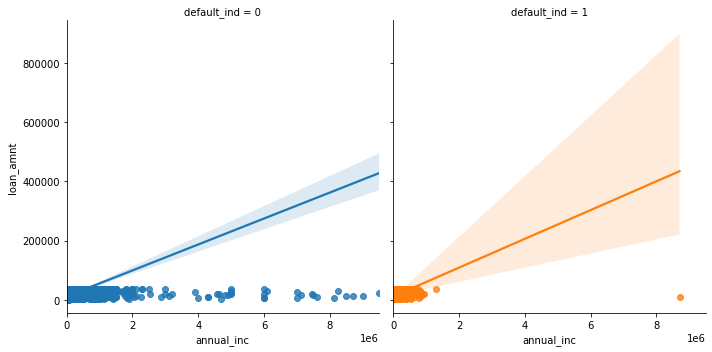

In [0]:
sns.lmplot('annual_inc','loan_amnt',data_num,col='default_ind',fit_reg=True,hue = 'default_ind')

In [0]:
slope,intercept,r_value,p_value,stnd_err = stats.linregress(data_num['annual_inc'],data_num['loan_amnt'])

In [0]:
print("Slope :",slope)
print("Intercept :",intercept)
print("R-Squared :",r_value**2)
print("P-Value :", p_value)
print("Error :",stnd_err)

Slope : 0.04394731714334344
Intercept : 11446.394736230135
R-Squared : 0.11236517220798697
P-Value : 0.0
Error : 0.00013350734616526032


The variables explain variance very poorly however they are significant as their p-value is 0.

### Let's check if debt to interest ratio(dti) is correlated to annual income 

In [0]:
data_num[['annual_inc','dti']].corr('spearman')

,annual_inc,dti
annual_inc,1.000000,-0.211412
dti,-0.211412,1.000000


In [0]:
data_num[data_num['default_ind']==1][['annual_inc','dti']].corr(method='spearman')

,annual_inc,dti
annual_inc,1.00000,-0.15307
dti,-0.15307,1.00000


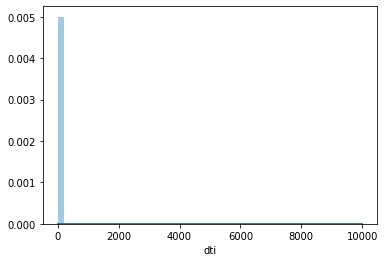

In [0]:
sns.distplot(data_num['dti'],hist=True)

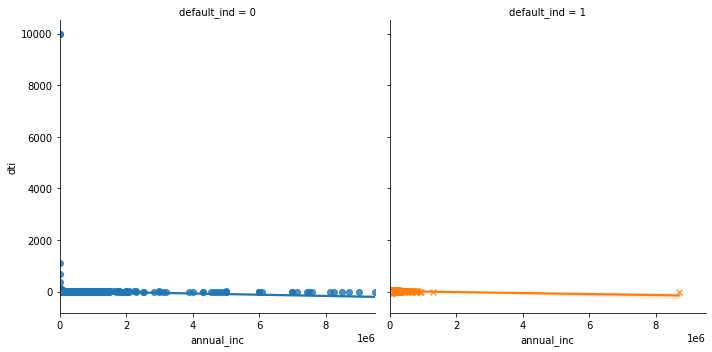

In [0]:
sns.lmplot('annual_inc','dti',data_num,hue='default_ind',col='default_ind',markers=['o','x'])

In [0]:
slope,intercept,r_value,p_value,stnd_err = stats.linregress(data_num['annual_inc'],data_num['dti'])

In [0]:
print("Slope :",slope)
print("Intercept :",intercept)
print("R-Squared :",r_value**2)
print("P-value :",p_value)
print("Error :",stnd_err)

Slope : -2.3539219813390403e-05
Intercept : 19.88928440369471
R-Squared : 0.007537871714098706
P-value : 0.0
Error : 2.9194171455515606e-07


### let's check the correlation between loan amount and interest rate.

In [0]:
data_num[['loan_amnt','int_rate']].corr('spearman')

,loan_amnt,int_rate
loan_amnt,1.00000,0.11449
int_rate,0.11449,1.00000


In [0]:
data_num[data_num['default_ind']==1][['loan_amnt','int_rate']].corr(method = 'spearman')

,loan_amnt,int_rate
loan_amnt,1.000000,0.254086
int_rate,0.254086,1.000000


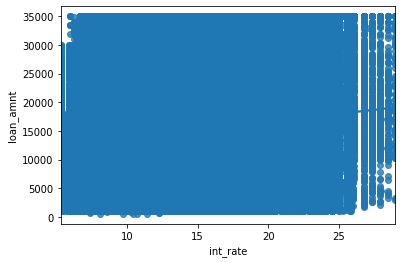

In [0]:
sns.regplot('int_rate','loan_amnt',data_num)

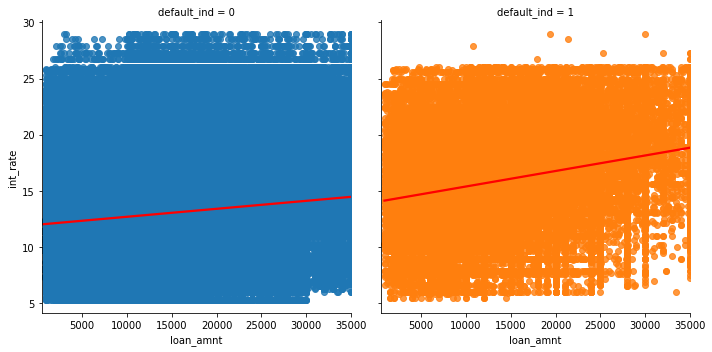

In [0]:
sns.lmplot('loan_amnt','int_rate',data_num,hue = 'default_ind',col = 'default_ind',line_kws = {'color':'red'})

In [0]:
slope,intercept,r_value,p_value,stnd_err = stats.linregress(data_num['loan_amnt'],data_num['int_rate'])
print("Slope :",slope)
print("Intercept :",intercept)
print("R-Squared :",r_value**2)
print("P-value :",p_value)
print("Error :",stnd_err)

Slope : 7.412511250608836e-05
Intercept : 12.099300828477269
R-Squared : 0.02043938061613563
P-value : 0.0
Error : 5.546495280061645e-07


### let's check correlation between interest rate and annual income

In [0]:
data_num[['int_rate','annual_inc']].corr('spearman')

,int_rate,annual_inc
int_rate,1.00000,-0.12416
annual_inc,-0.12416,1.00000


In [0]:
data_num[data_num['default_ind']==1][['int_rate','annual_inc']].corr('spearman')

,int_rate,annual_inc
int_rate,1.000000,0.070945
annual_inc,0.070945,1.000000


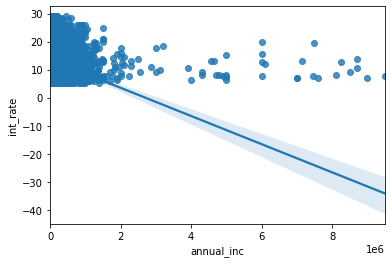

In [0]:
sns.regplot('annual_inc','int_rate',data_num)

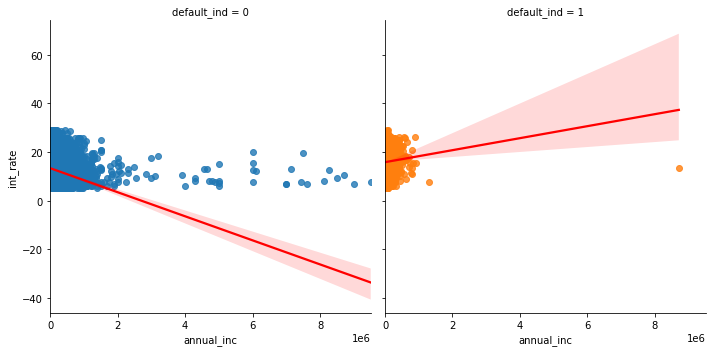

In [0]:
sns.lmplot('annual_inc','int_rate',data_num,col = 'default_ind',hue = 'default_ind',line_kws={'color':'red'})

In [0]:
slope,intercept,r_value,p_value,stnd_err = stats.linregress(data_num['annual_inc'],data_num['int_rate'])
print("Slope :",slope)
print("Intercept :",intercept)
print("R-Squared :",r_value**2)
print("P-value :",p_value)
print("Error :",stnd_err)

Slope : -5.018217426130775e-06
Intercept : 13.569041425549669
R-Squared : 0.0054500807194596155
P-value : 0.0
Error : 7.327111312806453e-08


## Most of the features in the data set are independant to each other and not so much positively or negatively correlated.

## Let's see the importance of the categorical variables to our target variable. 

I am going to use Cramer's v test to check the significance of each categoriacal variable and then it can be decided whether to drop or not. but before dropping the variable i am again going to run the data and extract feature importance towards our categoriacal data and choose accordingly.

In [0]:
data1.select_dtypes(include=object).columns

Index(['term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'pymnt_plan', 'desc',
       'purpose', 'title', 'zip_code', 'addr_state', 'initial_list_status',
       'application_type', 'verification_status_joint', 'issue_year',
       'issue_month', 'earliest_cr_line_year', 'earliest_cr_line_month',
       'last_pymnt_year', 'last_pymnt_month', 'next_pymnt_year',
       'next_pymnt_month', 'last_credit_pull_year', 'last_credit_pull_month'],
      dtype='object')

In [0]:
cat_cols = data1.drop(['emp_title','desc','title','issue_d','earliest_cr_line','last_pymnt_d','last_credit_pull_d','zip_code','issue_year','next_pymnt_d','issue_month','earliest_cr_line_year', 'earliest_cr_line_month', 'last_pymnt_year','last_pymnt_month', 'last_credit_pull_year', 'last_credit_pull_month','next_pymnt_year','next_pymnt_month','next_pymnt_day'],axis=1).select_dtypes(include = object)

In [0]:
# Cramer's v tests
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

for i in cat_cols:
  ctest = pd.crosstab(data1[i],data1['default_ind'])
  print(i,"test with target data")
  print( )
  (chi2,p,dof,_) = stats.chi2_contingency([ctest.iloc[0].values,ctest.iloc[1].values])
  print("Chi-Squared :",chi2)
  print("P-value :",p)
  print("Freedom :",dof)
  print("Cramer's test :",cramers_stat(ctest))
  print( )
  print( )

term test with target data

Chi-Squared : 842.4414293575821
P-value : 3.1976001603543985e-185
Freedom : 1
Cramer's test : default_ind
0    0.032260
1    0.134647
dtype: float64


grade test with target data

Chi-Squared : 1314.3485128104198
P-value : 8.611955702734528e-288
Freedom : 1
Cramer's test : default_ind
0    0.128677
1    0.537076
dtype: float64


sub_grade test with target data

Chi-Squared : 24.133085123523777
P-value : 8.990235936290843e-07
Freedom : 1
Cramer's test : default_ind
0    0.133062
1    0.555382
dtype: float64


emp_length test with target data

Chi-Squared : 3.608541810011949
P-value : 0.05748350114851429
Freedom : 1
Cramer's test : default_ind
0    0.024779
1    0.103746
dtype: float64


home_ownership test with target data

Chi-Squared : 0.942158352360233
P-value : 0.3317233861244474
Freedom : 1
Cramer's test : default_ind
0    0.037169
1    0.155137
dtype: float64


verification_status test with target data

Chi-Squared : 46.647621833132845
P-value : 8.49700

features like verification_status_joint ,initial_list_status ,pymnt_plan ,home_ownership ,emp_length does not show any significance towards our target variable.However,i think employment length can be a singnificant feature for prediction.

# Let's visualise the characteristics of deafaulters.



0    809502
1     46467
Name: default_ind, dtype: int64


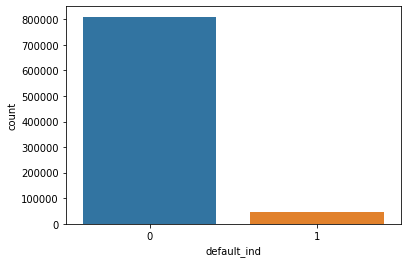

In [0]:
sns.countplot(data1['default_ind'])
print(data1.default_ind.value_counts())

In [0]:
data_group = data1.groupby('default_ind')
default_group = data_group.get_group(1)
nondefault_group = data_group.get_group(0)

In [0]:
print ("Percent of defaulters in this data is {}% !!!! .".format(len(default_group)/len(data1) * 100))

Percent of defaulters in this data is 5.428584446399344% !!!! .


Total Number of defaulters.
where 1 is the list of defaulters
and 0 is the list of non deafaulters

### Checking the loan amount opted by the defaulters.

In [0]:
default_group['loan_amnt'].max()

35000

In [0]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.93,0.96,0.99,1]:
  print(i*100,"% of the defaulter had opted for {} amount of loan.".format(default_group['loan_amnt'].quantile(i)))

10.0 % of the defaulter had opted for 5000.0 amount of loan.
20.0 % of the defaulter had opted for 7000.0 amount of loan.
30.0 % of the defaulter had opted for 9325.0 amount of loan.
40.0 % of the defaulter had opted for 10625.0 amount of loan.
50.0 % of the defaulter had opted for 12700.0 amount of loan.
60.0 % of the defaulter had opted for 15000.0 amount of loan.
70.0 % of the defaulter had opted for 18000.0 amount of loan.
80.0 % of the defaulter had opted for 21000.0 amount of loan.
90.0 % of the defaulter had opted for 27000.0 amount of loan.
93.0 % of the defaulter had opted for 30000.0 amount of loan.
96.0 % of the defaulter had opted for 34052.000000000044 amount of loan.
99.0 % of the defaulter had opted for 35000.0 amount of loan.
100 % of the defaulter had opted for 35000.0 amount of loan.


Considering that the amount is in dollar, that's a huge amount that the defaulter opted for.

In [0]:
len(default_group[default_group['loan_amnt']==35000])

1795

In [0]:
print("About {}% of defaulters had opted for the huge amount of 35000.".format(len(default_group[default_group['loan_amnt']==35000])/len(default_group) * 100))

About 3.862956506768244% of defaulters had opted for the huge amount of 35000.


### Let's See the employment length of the defaulters.

10.0    13508
2.0      4119
0.0      3942
3.0      3638
5.0      3280
1.0      3059
4.0      2841
6.0      2758
7.0      2673
8.0      2227
9.0      1826
Name: emp_length, dtype: int64


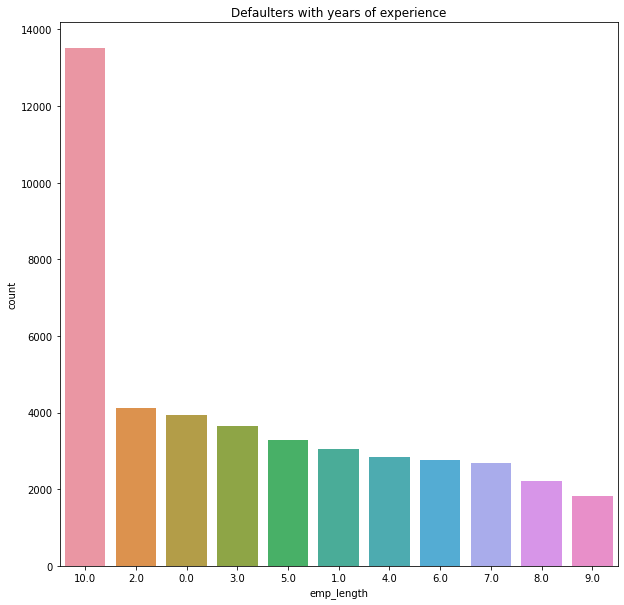

In [0]:
plt.figure(figsize=(10,10))
sns.countplot(default_group['emp_length'],order=default_group['emp_length'].value_counts().index)
plt.title('Defaulters with years of experience')
print(default_group['emp_length'].value_counts())

People with mostly 10 or more years of experince are more likely to default and after them comes the freshers with about 0-3 years of experince.

### Visualising installment affect on defaulters 

In [0]:
print("Max amount of monthly installment amount by the defaulters are {}.".format(default_group['installment'].max()))

Max amount of monthly installment amount by the defaulters are 1424.5699462890625.


In [0]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  print(i*100,'% defaulters had monthly installment of {} for their loan.'.format(default_group['installment'].quantile(i)))

10.0 % defaulters had monthly installment of 165.1199951171875 for their loan.
20.0 % defaulters had monthly installment of 233.60000610351562 for their loan.
30.0 % defaulters had monthly installment of 291.19000244140625 for their loan.
40.0 % defaulters had monthly installment of 340.17999267578125 for their loan.
50.0 % defaulters had monthly installment of 391.1700134277344 for their loan.
60.0 % defaulters had monthly installment of 460.9880004882812 for their loan.
70.0 % defaulters had monthly installment of 529.9600219726562 for their loan.
80.0 % defaulters had monthly installment of 627.510009765625 for their loan.
90.0 % defaulters had monthly installment of 788.2079956054688 for their loan.
100 % defaulters had monthly installment of 1424.5699462890625 for their loan.


Since there is almost double amount of jump after 90, it shows the person who must be taken huge amount of loan and has defaulted.

In [0]:
for i in [0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1]:
  print(i*100,'% defaulters had monthly installment of {} for their loan.'.format(default_group['installment'].quantile(i)))

90.0 % defaulters had monthly installment of 788.2079956054688 for their loan.
91.0 % defaulters had monthly installment of 814.2100219726562 for their loan.
92.0 % defaulters had monthly installment of 842.3499755859375 for their loan.
93.0 % defaulters had monthly installment of 866.52001953125 for their loan.
94.0 % defaulters had monthly installment of 891.3412255859375 for their loan.
95.0 % defaulters had monthly installment of 927.3610168457021 for their loan.
96.0 % defaulters had monthly installment of 965.1980224609378 for their loan.
97.0 % defaulters had monthly installment of 1006.2421899414059 for their loan.
98.0 % defaulters had monthly installment of 1088.18994140625 for their loan.
99.0 % defaulters had monthly installment of 1212.949951171875 for their loan.
100 % defaulters had monthly installment of 1424.5699462890625 for their loan.


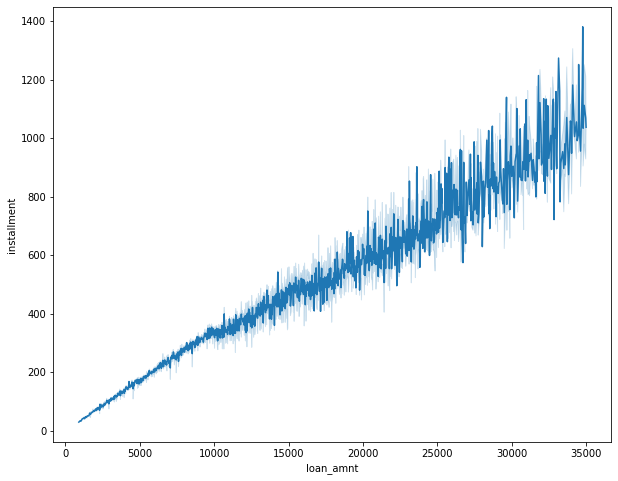

In [0]:
plt.figure(figsize=(10,8))
sns.lineplot(default_group['loan_amnt'],default_group['installment'])

It's obvious that people taking higher amount of loan will pay more installment amount per month.

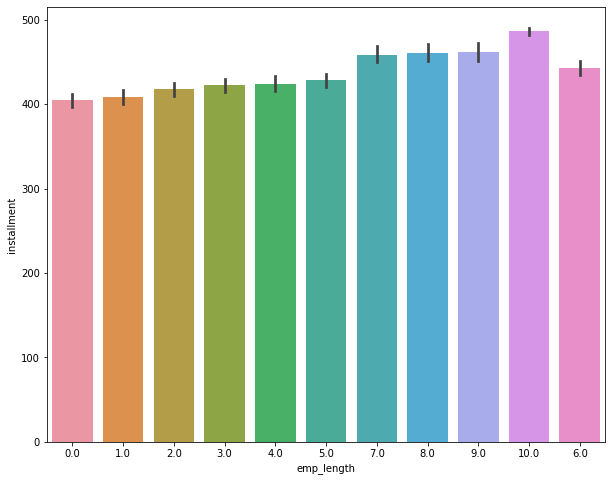

In [0]:
plt.figure(figsize=(10,8))
sns.barplot(default_group['emp_length'],default_group['installment'])

People with higher experience tends to pay more monthly installments,which makes sense that people with more years of experience will have more monthly income so they will opt for more amount of loan.

### Checking the annual income of defaulters

In [0]:
default_group['annual_inc'].max()

8706582.0

It's strange that people with so high income defaulting,maybe they forgot to pay or maybe they got stuck.

In [0]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]:
  print(i*100,'% people earned',default_group['annual_inc'].quantile(i))

10.0 % people earned 30000.0
20.0 % people earned 38000.0
30.0 % people earned 44000.0
40.0 % people earned 50000.0
50.0 % people earned 56000.0
60.0 % people earned 64000.0
70.0 % people earned 72000.0
80.0 % people earned 85000.0
90.0 % people earned 105000.0
100 % people earned 8706582.0


Clearly the jump after the 90 percent shows the presence of sum outlier. let's see between the 90-100 range.

In [0]:
for i in [0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99,1]:
  print(i*100,'% people earned',default_group['annual_inc'].quantile(i))

90.0 % people earned 105000.0
91.0 % people earned 110000.0
92.0 % people earned 115000.0
93.0 % people earned 120000.0
94.0 % people earned 124800.0
95.0 % people earned 130000.0
96.0 % people earned 140000.0
97.0 % people earned 150000.0
98.0 % people earned 170000.0
99.0 % people earned 200000.0
100 % people earned 8706582.0


This confirms the presence of the outlier

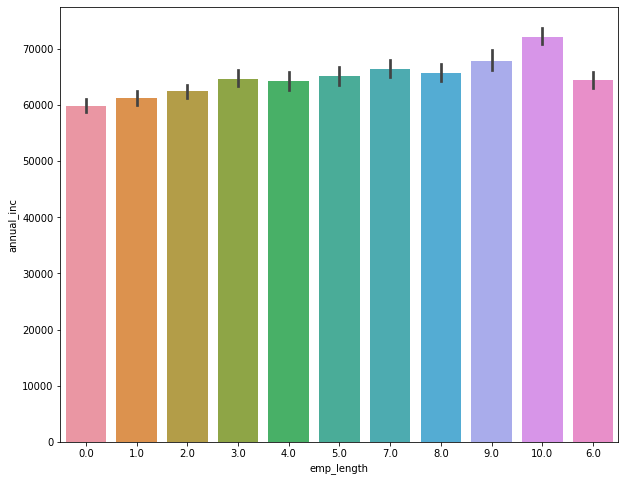

In [0]:
plt.figure(figsize=(10,8))
sns.barplot(default_group['emp_length'],default_group['annual_inc'])

As expected higher experience level means more the amount earned.Let's see if there are any talents with less years of experience and earning more.

In [0]:
print(len(default_group[(default_group['annual_inc']>180000 ) & (default_group['emp_length']<=3)]))
print()
default_group[(default_group['annual_inc']>150000 ) & (default_group['emp_length']<=3)].head(5)

237



,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind,issue_year,issue_month,issue_day,earliest_cr_line_year,earliest_cr_line_month,earliest_cr_line_day,last_pymnt_year,last_pymnt_month,last_pymnt_day,next_pymnt_year,next_pymnt_month,next_pymnt_day,last_credit_pull_year,last_credit_pull_month,last_credit_pull_day
597,1062257,1294315,22200,22200,22200.000000,36 months,19.420000,818.489990,E,E3,Grace & Growth Family Services,2,RENT,160000.0,Source Verified,2011-12-01,n,NaN,debt_consolidation,debt consolidation,912xx,CA,13.330000,0,1996-10-01,1,69.0,NaN,12,0,10070,89.099998,25,f,0.0,0.0,9174.610352,9174.610352,4940.209961,3242.590088,0.000000,991.809998,9.8100,2012-10-01,818.489990,NaT,2013-03-01,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2011,12,1,1996,10,1,2012,10,1.0,NaN,NaN,NaN,2013,3,1.0
1464,1050329,1281759,30000,30000,30000.000000,60 months,20.299999,799.840027,E,E5,Tampa Bay Storm,0,MORTGAGE,525000.0,Verified,2011-12-01,n,Borrower added on 12/01/11 > consolidate my ...,other,Consolidation,335xx,FL,8.500000,0,2000-09-01,0,64.0,NaN,14,0,37725,75.000000,42,f,0.0,0.0,5780.419922,5780.419922,1828.290039,2966.489990,0.000000,985.640015,10.0400,2012-07-01,799.840027,NaT,2012-11-01,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2011,12,1,2000,9,1,2012,7,1.0,NaN,NaN,NaN,2012,11,1.0
1692,1047248,1278330,35000,35000,34963.332031,60 months,23.129999,989.289978,G,G2,Merrill Lynch,3,MORTGAGE,220000.0,Source Verified,2011-12-01,n,NaN,home_improvement,Home improvement loan,926xx,CA,18.360001,0,2000-03-01,3,NaN,NaN,8,0,51941,93.199997,28,f,0.0,0.0,11699.830078,11656.240234,3431.530029,6453.970215,0.000000,1814.329956,18.0000,2012-10-01,989.289978,NaT,2013-03-01,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2011,12,1,2000,3,1,2012,10,1.0,NaN,NaN,NaN,2013,3,1.0
2617,1033948,1263735,12000,12000,12000.000000,36 months,14.270000,411.709991,C,C2,Halliburton,0,RENT,159500.0,Source Verified,2011-11-01,n,NaN,credit_card,Credit Card,774xx,TX,13.710000,0,1989-02-01,0,73.0,NaN,15,0,19682,83.300003,39,f,0.0,0.0,14285.059570,14285.059570,11170.879883,2806.719971,120.809998,186.649994,33.5970,2015-04-01,60.520000,NaT,2015-07-01,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2011,11,1,1989,2,1,2015,4,1.0,NaN,NaN,NaN,2015,7,1.0
3161,1020621,1249409,35000,35000,34822.566406,60 months,20.299999,933.140015,E,E5,Kone Inc,0,MORTGAGE,191000.0,Verified,2011-11-01,n,NaN,house,Pay off homes Loans,701xx,LA,17.719999,2,1994-11-01,1,3.0,NaN,16,0,14925,75.199997,43,f,0.0,0.0,25126.300781,24994.259766,9482.389648,11957.059570,0.000000,3686.850098,36.6408,2013-11-01,933.140015,NaT,2014-03-01,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2011,11,1,1994,11,1,2013,11,1.0,NaN,NaN,NaN,2014,3,1.0


So there are indeed 237 of people with less experience but high income,makes sense they defaulted.

Let's see if annual income has anything to do with monthly installment or not.

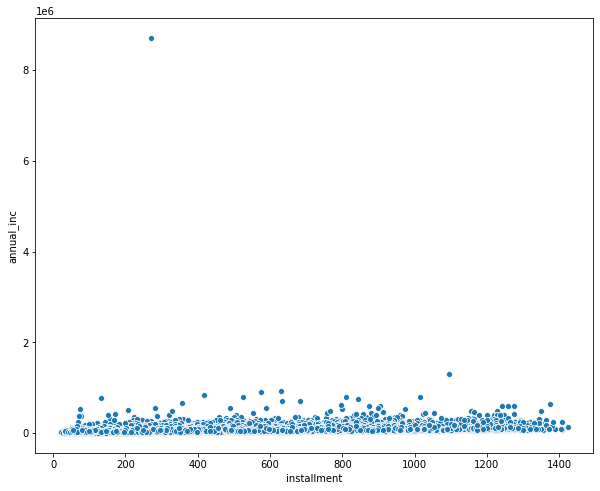

In [0]:
plt.figure(figsize=(10,8))
sns.scatterplot(default_group['installment'],default_group['annual_inc'])

This shows that Monthly income does not affect the amount of installments paid for the loan.

### Let's visualize the last delinquency of the defaulter

In [0]:
len(default_group['mths_since_last_delinq'])

46467

In [0]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.93,0.96,0.99,1]:
  print(i*100,"% of defaulters were {} months since last delinquency.".format(default_group['mths_since_last_delinq'].quantile(i)))

10.0 % of defaulters were 8.0 months since last delinquency.
20.0 % of defaulters were 13.0 months since last delinquency.
30.0 % of defaulters were 18.0 months since last delinquency.
40.0 % of defaulters were 24.0 months since last delinquency.
50.0 % of defaulters were 31.0 months since last delinquency.
60.0 % of defaulters were 38.0 months since last delinquency.
70.0 % of defaulters were 46.0 months since last delinquency.
80.0 % of defaulters were 56.0 months since last delinquency.
90.0 % of defaulters were 68.0 months since last delinquency.
93.0 % of defaulters were 72.0 months since last delinquency.
96.0 % of defaulters were 76.0 months since last delinquency.
99.0 % of defaulters were 81.0 months since last delinquency.
100 % of defaulters were 152.0 months since last delinquency.


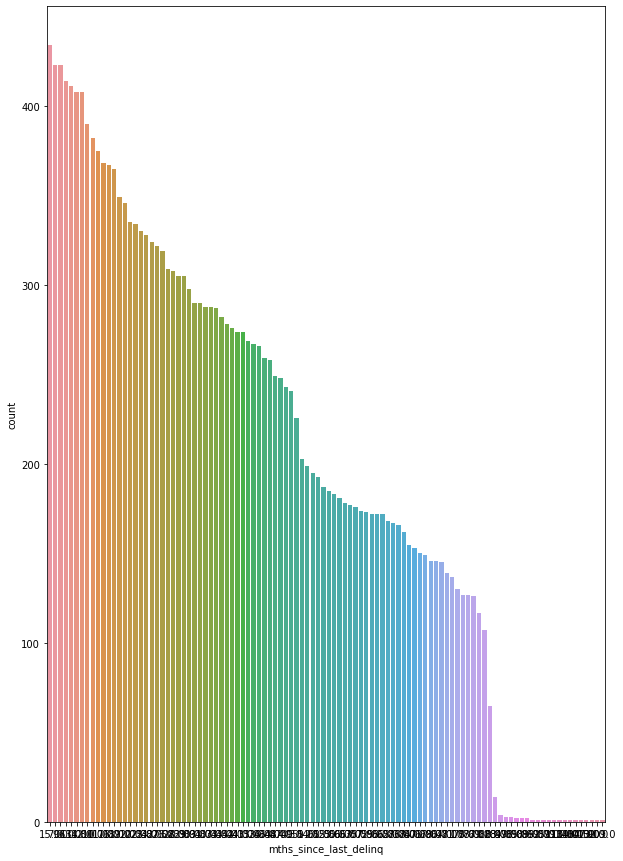

In [0]:
plt.figure(figsize=(10,15))
sns.countplot(default_group['mths_since_last_delinq'],order=default_group['mths_since_last_delinq'].value_counts().index)

### let's see which state had the most number of defaulters.

In [0]:
default_group['addr_state'].value_counts().head(5)

CA    7543
NY    4230
FL    3619
TX    3146
NJ    1890
Name: addr_state, dtype: int64

Turns out california,new york,texas,florida and illionos were the top states where the number of defaulters were present,with california having the most of them. 

In [0]:
print("FOR CA {} %".format(len(default_group[default_group['addr_state']=="CA"])/len(data1[data1['addr_state']=="CA"]) * 100))
print("FOR NY {} %".format(len(default_group[default_group['addr_state']=="NY"])/len(data1[data1['addr_state']=="NY"]) * 100))

FOR CA 6.026108075288404 %
FOR NY 5.9481958545434095 %


In [0]:
default_group['addr_state'].value_counts().tail(5)

WY    83
VT    71
NE     4
ID     1
IA     1
Name: addr_state, dtype: int64

In [0]:
print("FOR CA {} %".format(len(default_group[default_group['addr_state']=="IA"])/len(data1[data1['addr_state']=="IA"]) * 100))

FOR CA 14.285714285714285 %


In [0]:
state = default_group.addr_state.unique()
state

array(['GA', 'CA', 'TX', 'VA', 'FL', 'NY', 'PA', 'OH', 'IL', 'WA', 'MN',
       'AK', 'OR', 'AZ', 'WI', 'NC', 'CO', 'MO', 'WV', 'NV', 'SC', 'RI',
       'MA', 'KY', 'HI', 'NJ', 'MT', 'MI', 'SD', 'DC', 'OK', 'VT', 'NM',
       'MD', 'AL', 'KS', 'UT', 'LA', 'AR', 'CT', 'NH', 'DE', 'WY', 'MS',
       'TN', 'ID', 'NE', 'IN', 'IA'], dtype=object)

In [0]:
for i in state:
  print("TOTAL OF {} ".format(len(data1[data1['addr_state']==i])) ,"HAD APPLIED FOR LOAN IN",i,"AND ONLY {}".format(len(default_group[default_group['addr_state']==i])) ,"DEFAULTED,THAT'S {} % ". format(len(default_group[default_group['addr_state']==i])/len(data1[data1['addr_state']==i]) * 100))
  print(" ")

TOTAL OF 28043  HAD APPLIED FOR LOAN IN GA AND ONLY 1396 DEFAULTED,THAT'S 4.978069393431516 % 
 
TOTAL OF 125172  HAD APPLIED FOR LOAN IN CA AND ONLY 7543 DEFAULTED,THAT'S 6.026108075288404 % 
 
TOTAL OF 68708  HAD APPLIED FOR LOAN IN TX AND ONLY 3146 DEFAULTED,THAT'S 4.578797228852535 % 
 
TOTAL OF 25234  HAD APPLIED FOR LOAN IN VA AND ONLY 1467 DEFAULTED,THAT'S 5.81358484584291 % 
 
TOTAL OF 58639  HAD APPLIED FOR LOAN IN FL AND ONLY 3619 DEFAULTED,THAT'S 6.171660498985316 % 
 
TOTAL OF 71114  HAD APPLIED FOR LOAN IN NY AND ONLY 4230 DEFAULTED,THAT'S 5.9481958545434095 % 
 
TOTAL OF 30250  HAD APPLIED FOR LOAN IN PA AND ONLY 1596 DEFAULTED,THAT'S 5.27603305785124 % 
 
TOTAL OF 28651  HAD APPLIED FOR LOAN IN OH AND ONLY 1512 DEFAULTED,THAT'S 5.277302711947227 % 
 
TOTAL OF 34379  HAD APPLIED FOR LOAN IN IL AND ONLY 1570 DEFAULTED,THAT'S 4.566741324645859 % 
 
TOTAL OF 18816  HAD APPLIED FOR LOAN IN WA AND ONLY 1008 DEFAULTED,THAT'S 5.357142857142857 % 
 
TOTAL OF 15424  HAD APPLIED FO

SO,even though the number of deafaulters in california were high the percentage of defaulters in that state was pretty low comparitively,However places like idaho had maximum percent of defaulters as the total loan issued over there were low still the default happened.

### Let's check the total number of credit lines with the defaulters.

In [0]:
print(default_group['total_acc'].max())
print(" ")
print(default_group['total_acc'].min())

110
 
2


In [0]:
default_group['total_acc'].sort_values()

167872      2
38585       2
141145      2
418411      2
39008       3
         ... 
311529     92
271494     92
338733     94
774694     98
844502    110
Name: total_acc, Length: 46467, dtype: int16

In [0]:
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.93,0.96,0.99,1]:
  print(i*100," % of defaulters had {} number of credit lines with them.".format(default_group['total_acc'].quantile(i)))

10.0  % of defaulters had 11.0 number of credit lines with them.
20.0  % of defaulters had 14.0 number of credit lines with them.
30.0  % of defaulters had 17.0 number of credit lines with them.
40.0  % of defaulters had 20.0 number of credit lines with them.
50.0  % of defaulters had 23.0 number of credit lines with them.
60.0  % of defaulters had 25.0 number of credit lines with them.
70.0  % of defaulters had 29.0 number of credit lines with them.
80.0  % of defaulters had 33.0 number of credit lines with them.
90.0  % of defaulters had 40.0 number of credit lines with them.
93.0  % of defaulters had 43.0 number of credit lines with them.
96.0  % of defaulters had 47.0 number of credit lines with them.
99.0  % of defaulters had 59.0 number of credit lines with them.
100  % of defaulters had 110.0 number of credit lines with them.


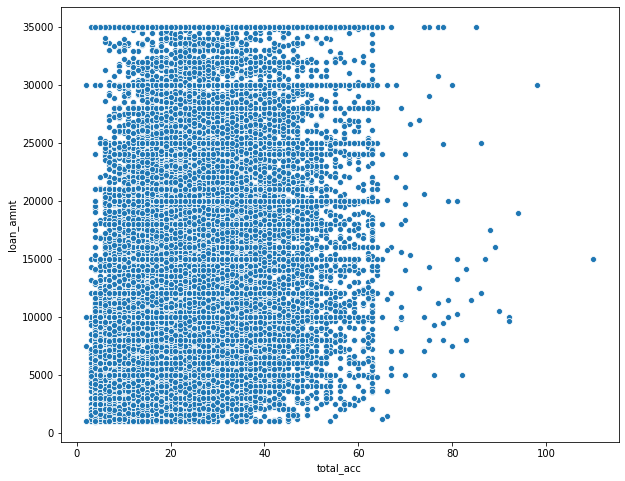

In [0]:
plt.figure(figsize=(10,8))
sns.scatterplot(default_group['total_acc'].sort_values(),default_group['loan_amnt'])

Most of the defaulters had line of credits between 0-50.

Let's analyze the verification status

In [0]:
data1['verification_status'].value_counts()

Source Verified    318178
Verified           280049
Not Verified       257742
Name: verification_status, dtype: int64

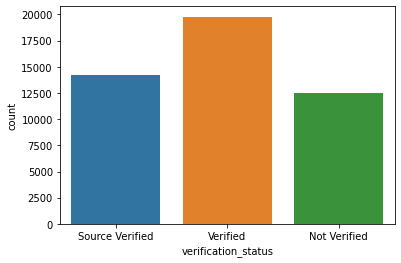

In [0]:
sns.countplot(default_group['verification_status'])

Most of the defaulters were verified,which is explainable as no bank gives loan without verifying.

## Let's see which issue year had maximum defaulter.

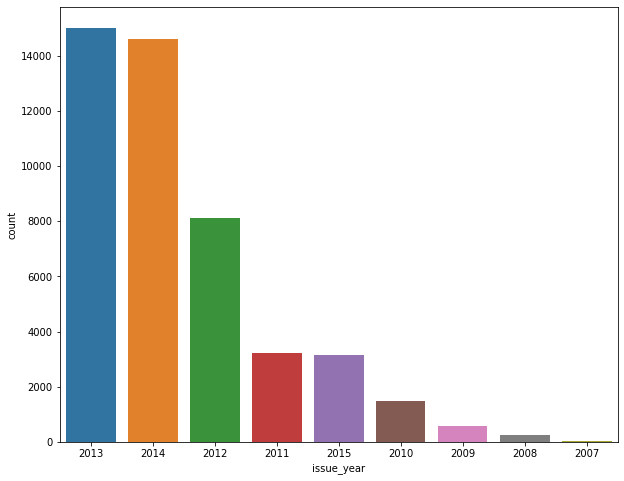

In [0]:
plt.figure(figsize=(10,8))
sns.countplot(default_group['issue_year'],order = default_group['issue_year'].value_counts().index)

let's see how much loan people asked for in every year.

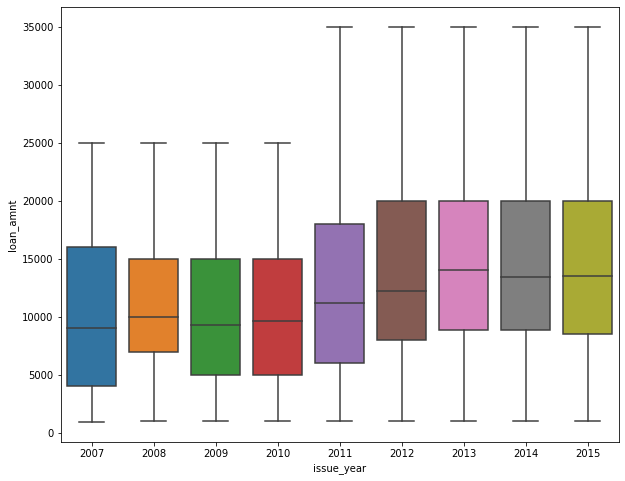

In [0]:
plt.figure(figsize=(10,8))
sns.boxplot(default_group['issue_year'],data1['loan_amnt'])

Turns out people in earlier years applied for lesser loan amount which justifies why people between 2013 to 2015 defaults so much.

## Let's see which month had the maximum defaulters

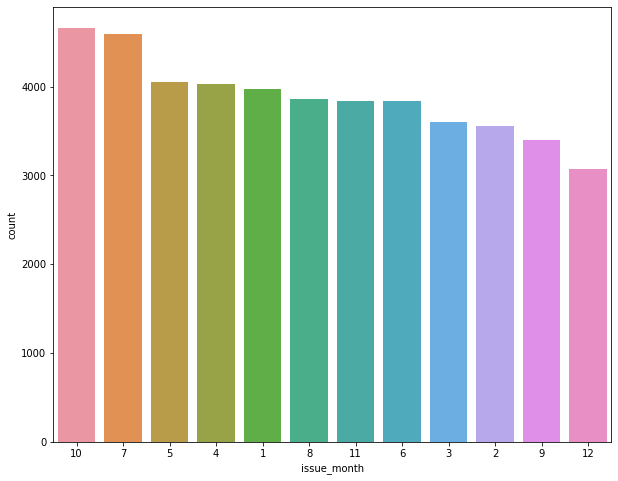

In [0]:
plt.figure(figsize = (10,8))
sns.countplot(default_group['issue_month'],order = default_group['issue_month'].value_counts().index)

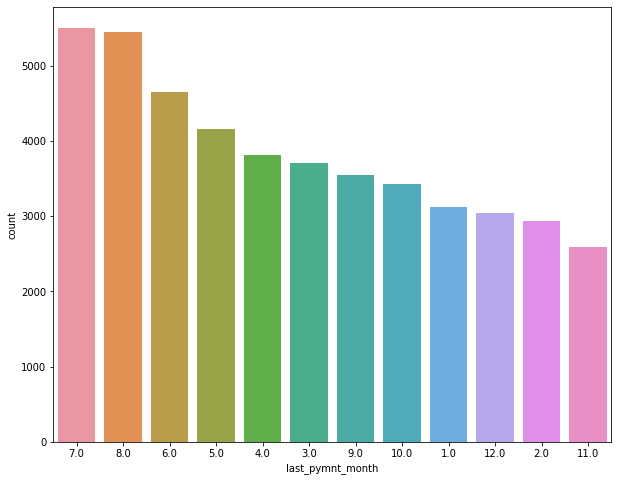

In [0]:
plt.figure(figsize=(10,8))
sns.countplot(default_group['last_pymnt_month'],order = default_group['last_pymnt_month'].value_counts().index)

Mostly people applied for loan during october as in november and december thanksgiving is there.That also explains why the defaulters last payment in their tenure was during july and aug. 


# CLEANING DATA FOR MODELLING

In [0]:
check_missing_data(data1)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind,issue_year,issue_month,issue_day,earliest_cr_line_year,earliest_cr_line_month,earliest_cr_line_day,last_pymnt_year,last_pymnt_month,last_pymnt_day,next_pymnt_year,next_pymnt_month,next_pymnt_day,last_credit_pull_year,last_credit_pull_month,last_credit_pull_day
Total,0,0,0,0,0,0,0,0,0,0,49443,43061,0,0,0,0,0,734157,0,33,0,0,0,0,0,0,439812,724785,0,0,0,446,0,0,0,0,0,0,0,0,0,0,0,8862,0,252971,50,56,642830,0,0,855527,855529,855527,0,67313,67313,842681,842681,842681,842681,843035,842681,844360,842681,842681,842681,842681,67313,842681,842681,842681,0,0,0,0,0,0,0,8862,8862,8862,252971,252971,252971,50,50,50
Percent,0,0,0,0,0,0,0,0,0,0,5.77626,5.03067,0,0,0,0,0,85.7691,0,0.00385528,0,0,0,0,0,0,51.3818,84.6742,0,0,0,0.0521047,0,0,0,0,0,0,0,0,0,0,0,1.03532,0,29.5538,0.00584133,0.00654229,75.0997,0,0,99.9484,99.9486,99.9484,0,7.86395,7.86395,98.4476,98.4476,98.4476,98.4476,98.489,98.4476,98.6438,98.4476,98.4476,98.4476,98.4476,7.86395,98.4476,98.4476,98.4476,0,0,0,0,0,0,0,1.03532,1.03532,1.03532,29.5538,29.5538,29.5538,0.00584133,0.00584133,0.00584133
Types,int32,int32,int32,int32,float32,object,float32,float32,object,object,object,object,object,float32,object,datetime64[ns],object,object,object,object,object,object,float32,int8,datetime64[ns],int8,float32,float32,int8,int8,int32,float32,int16,object,float32,float32,float32,float32,float32,float32,float32,float32,float32,datetime64[ns],float32,datetime64[ns],datetime64[ns],float32,float32,int8,object,float32,float32,object,int8,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int8,object,object,int64,object,object,int64,object,object,float64,object,object,float64,object,object,float64


Removing columns with more than 70% of missing data also the columns of no use.

In [0]:
data1.shape

(855969, 88)

In [0]:
data_new = data1.drop(['id','member_id','desc','issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d','mths_since_last_record','mths_since_last_major_derog','annual_inc_joint','dti_joint','verification_status_joint','open_acc_6m','open_il_6m','open_il_12m','policy_code','open_il_24m','mths_since_rcnt_il','total_bal_il','il_util','open_rv_12m','open_rv_24m','max_bal_bc','all_util','inq_fi','total_cu_tl','inq_last_12m','issue_day','earliest_cr_line_day','last_pymnt_day','next_pymnt_day','next_pymnt_month','next_pymnt_year','last_credit_pull_day'],axis=1)

In [0]:
data_new.shape

(855969, 53)

# Filling in the missing data

In [0]:
data_new['mths_since_last_delinq'].fillna(0,inplace = True)
data_new['mths_since_last_delinq'].fillna(0,inplace = True)

### filling the defaulters data and dropping the non defaulters null value.

In [0]:
data_newgroup = data_new.groupby('default_ind')
data_1 = data_newgroup.get_group(1)
data_0 = data_newgroup.get_group(0)
print(data_1['default_ind'].value_counts())

1    46467
Name: default_ind, dtype: int64


In [0]:
check_missing_data(data_1)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_ind,issue_year,issue_month,earliest_cr_line_year,earliest_cr_line_month,last_pymnt_year,last_pymnt_month,last_credit_pull_year,last_credit_pull_month
Total,0,0,0,0,0,0,0,0,3519,2596,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,10037,10037,10037,0,0,0,0,0,536,536,6,6
Percent,0,0,0,0,0,0,0,0,7.57312,5.58676,0,0,0,0,0,0.00430413,0,0,0,0,0,0,0,0,0,0.103299,0,0,0,0,0,0,0,0,0,0,0,0,0.0129124,0,0,21.6003,21.6003,21.6003,0,0,0,0,0,1.15351,1.15351,0.0129124,0.0129124
Types,int32,int32,float32,object,float32,float32,object,object,object,object,object,float32,object,object,object,object,object,object,float32,int8,int8,float32,int8,int8,int32,float32,int16,object,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,object,int8,float32,float32,float32,int8,object,object,object,object,object,object,object,object


In [0]:
len(data1[data1['tot_coll_amt']==0])

677062

In [0]:
data_1['tot_coll_amt'].fillna(0,inplace = True)
data_1['tot_cur_bal'].fillna(0,inplace = True)
data_1['total_rev_hi_lim'].fillna(0,inplace = True)
#data_1['next_pymnt_year'].fillna(0000,inplace=True)
#data_1['next_pymnt_month'].fillna(00,inplace = True)

In [0]:
data_1.dropna(axis=0,inplace=True)

In [0]:
data_0.dropna(axis=0,inplace=True)

In [0]:
data_new1 = pd.concat([data_1,data_0])
print(data_1.shape)
print(data_0.shape)
print(data_new1.shape)
print(data_new.shape)

(42375, 53)
(701197, 53)
(743572, 53)
(855969, 53)


In [0]:
check_missing_data(data_new1)

False

# Feature selection

## Let's check the importance of categorical features with respect to target variable.

In [0]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder

In [0]:
data_enc = data_new1.apply(LabelEncoder().fit_transform)

In [0]:
x = data_enc.drop('default_ind',axis=1)
y = data_enc['default_ind']

In [0]:
etr = ExtraTreesClassifier().fit(x,y)

In [0]:
print(etr.feature_importances_)

[2.75949224e-02 2.51146104e-02 3.01239761e-02 1.79705699e-02
 5.10163073e-03 2.76251197e-02 3.50353129e-03 2.83455010e-03
 8.89925209e-04 8.30785561e-04 7.85736226e-04 1.39286982e-03
 1.44106993e-03 0.00000000e+00 1.23367040e-03 2.01474507e-03
 9.04384383e-04 8.56482483e-04 1.30698633e-03 5.91584050e-04
 8.73145469e-04 7.63509147e-04 9.62573771e-04 4.91665232e-04
 1.96737711e-03 1.09918952e-03 9.13695984e-04 2.97774086e-03
 5.52027249e-02 4.26686310e-02 3.87481130e-02 3.66052792e-02
 8.76338394e-02 1.39547927e-02 7.30218679e-03 1.55724882e-01
 1.29522027e-01 6.69920395e-02 9.39899510e-05 0.00000000e+00
 4.70841047e-05 5.09808953e-04 5.23693868e-03 8.10421728e-03
 3.62142144e-02 3.77965127e-03 9.03028626e-04 8.29431722e-04
 5.59748957e-02 5.57518955e-02 1.53103631e-02 2.07239189e-02]


In [0]:
feature_importances = pd.DataFrame((etr.feature_importances_ * 100),index = x.columns,columns=['importance']).sort_values('importance',ascending=False)

In [0]:
feature_importances

,importance
recoveries,15.572488
collection_recovery_fee,12.952203
total_rec_prncp,8.763384
last_pymnt_amnt,6.699204
last_pymnt_year,5.597490
last_pymnt_month,5.575190
out_prncp,5.520272
out_prncp_inv,4.266863
total_pymnt,3.874811
total_pymnt_inv,3.660528


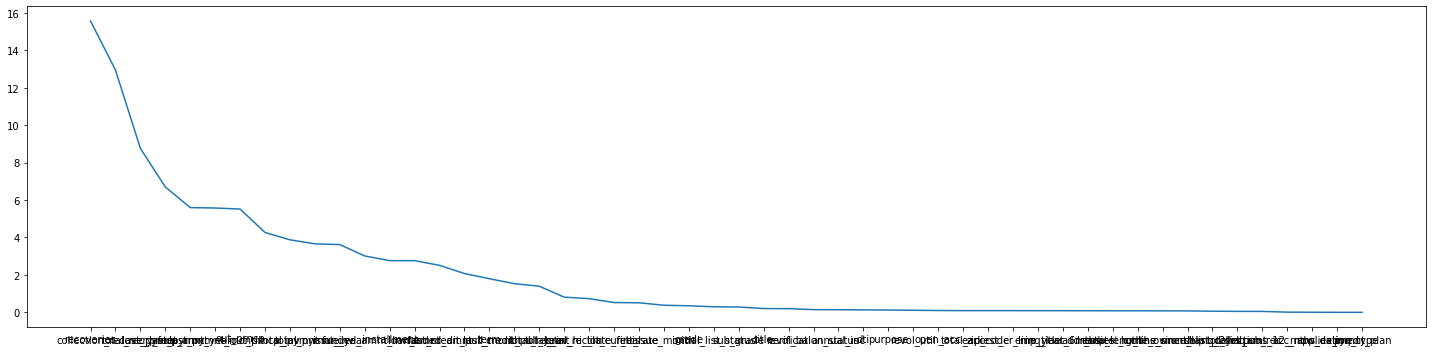

In [0]:
plt.figure(figsize=(20,5))
plt.plot(feature_importances)
plt.tight_layout()

In [0]:
feature_importances[feature_importances['importance']<0.1].index

Index(['open_acc', 'total_acc', 'zip_code', 'earliest_cr_line_year',
       'emp_title', 'inq_last_6mths', 'addr_state', 'emp_length',
       'earliest_cr_line_month', 'home_ownership', 'mths_since_last_delinq',
       'delinq_2yrs', 'tot_coll_amt', 'pub_rec', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'application_type', 'pymnt_plan'],
      dtype='object')

Dropping variables with less than 0.1 feature importance,because that's where a elbow of the graph can be seen.
Also,earlier in the cramer's v test,most of the categorical variables predicted to not be significant to the target variables was seen and confirmed by this test.

In [0]:
data_enc.drop(['total_acc', 'zip_code', 'earliest_cr_line_year', 'emp_title',
       'inq_last_6mths', 'addr_state', 'earliest_cr_line_month',
       'home_ownership', 'emp_length', 'mths_since_last_delinq', 'delinq_2yrs',
       'tot_coll_amt', 'pub_rec', 'collections_12_mths_ex_med',
       'acc_now_delinq', 'application_type', 'pymnt_plan'],axis=1,inplace =True)

In [0]:
print(data_new1.shape)
print(data_enc.shape)

(743572, 53)
(743572, 36)


# Applying Supervised Learning on the new data with only important features

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,roc_auc_score,roc_curve,precision_score,recall_score

In [0]:
data_enc.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'annual_inc',
       'verification_status', 'purpose', 'title', 'dti', 'open_acc',
       'revol_bal', 'revol_util', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'tot_cur_bal',
       'total_rev_hi_lim', 'default_ind', 'issue_year', 'issue_month',
       'last_pymnt_year', 'last_pymnt_month', 'last_credit_pull_year',
       'last_credit_pull_month'],
      dtype='object')

In [0]:
X = data_enc.drop('default_ind',axis=1)
Y = data_enc['default_ind']

In [0]:
x_train,x_val,y_train,y_val = train_test_split(X,Y,test_size = 0.1,random_state = 200)

In [0]:
print(x_val.shape)
print(y_val.shape)

(74358, 35)
(74358,)


## Logistic Regression

In [0]:
Log_model = LogisticRegression().fit(x_train,y_train)
Logtrainpred = Log_model.predict(x_train)
Log_pred = Log_model.predict(x_val)

Train accuracy

In [0]:
print(confusion_matrix(y_train,Logtrainpred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_train,Logtrainpred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_train,Logtrainpred)))

[[630623    405]
 [  2961  35225]]

accuracy of the model is 0.9949702187939882 .

F1_score of the model on train is 0.954400130053105.


Validation accuaracy

[[70123    46]
 [  328  3861]]

accuracy of the model is 0.9949702789208962 .

Precision of the model is 0.9882262605579729 .

Recall of the model is 0.9216996896634042 .

F1_score of the model on train is 0.953804347826087.

ROC-AUC is :-
roc_auc_score of Logistic Regression:  0.9605220647578803


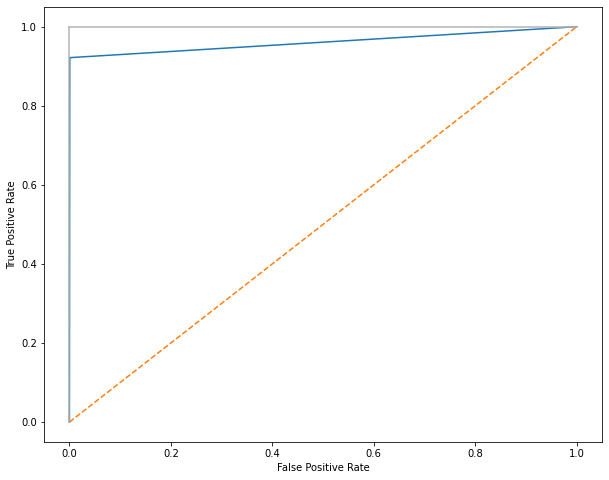

In [0]:
print(confusion_matrix(y_val,Log_pred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_val,Log_pred)))
print( )
print("Precision of the model is {} .".format(precision_score(y_val,Log_pred)))
print( )
print("Recall of the model is {} .".format(recall_score(y_val,Log_pred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_val,Log_pred)))
print( )
print("ROC-AUC is :-")
fpr_log,tpr_log,thres_log = roc_curve(y_val,Log_pred)
print("roc_auc_score of Logistic Regression: ",roc_auc_score(y_val,Log_pred))
plt.figure(figsize=(10,8))
plt.plot(fpr_log,tpr_log)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7")
plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## ExtraTreeClassifier

In [0]:
etr_model = ExtraTreesClassifier().fit(x_train,y_train)
etrtrainpred = etr_model.predict(x_train)
etr_pred = etr_model.predict(x_val)

Train accuracy

In [0]:
print(confusion_matrix(y_train,etrtrainpred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_train,etrtrainpred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_train,etrtrainpred)))

[[631028      0]
 [     0  38186]]

accuracy of the model is 1.0 .

F1_score of the model on train is 1.0.


Validation accuracy

[[70169     0]
 [   37  4152]]

accuracy of the model is 0.9995024072729228 .

Precision of the model is 1.0 .

Recall of the model is 0.9911673430412986 .

F1_score of the model on train is 0.9955640810454381.

ROC_AUC of ExtraTree Classifier :-
roc_auc_score is:  0.9955836715206493


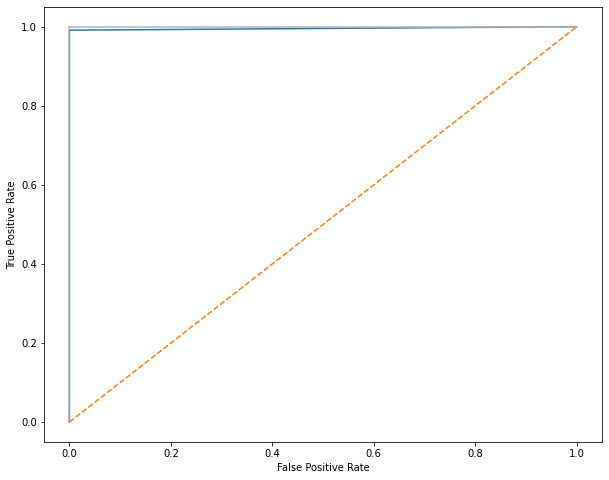

In [0]:
print(confusion_matrix(y_val,etr_pred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_val,etr_pred)))
print( )
print("Precision of the model is {} .".format(precision_score(y_val,etr_pred)))
print( )
print("Recall of the model is {} .".format(recall_score(y_val,etr_pred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_val,etr_pred)))
print( )
print("ROC_AUC of ExtraTree Classifier :-")
fpr_etr,tpr_etr,thres_etr=roc_curve(y_val,etr_pred)
print("roc_auc_score is: ", roc_auc_score(y_val,etr_pred))
plt.figure(figsize=(10,8))
plt.plot(fpr_etr,tpr_etr)
plt.plot([0,1],ls = "--")
plt.plot([0,0],[1,0],c="0.7")
plt.plot([1,1],c="0.7")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## RandomForestClassifier

In [0]:
rnd_model = RandomForestClassifier().fit(x_train,y_train)
rndtrainpred = rnd_model.predict(x_train)
rnd_pred = rnd_model.predict(x_val)

train accuracy

In [0]:
print(confusion_matrix(y_train,rndtrainpred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_train,rndtrainpred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_train,rndtrainpred)))

[[631028      0]
 [     0  38186]]

accuracy of the model is 1.0 .

F1_score of the model on train is 1.0.


Validation accuracy

[[70169     0]
 [   34  4155]]

accuracy of the model is 0.9995427526291724 .

Precision of the model is 1.0 .

Recall of the model is 0.9918835044163284 .

F1_score of the model on train is 0.9959252157238735.

ROC_AUC of RandomForest Classifier is: 
roc_auc_score is :  0.9959417522081642


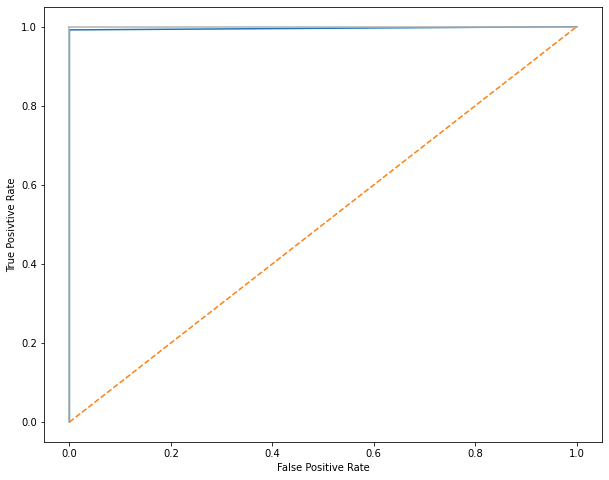

In [0]:
print(confusion_matrix(y_val,rnd_pred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_val,rnd_pred)))
print( )
print("Precision of the model is {} .".format(precision_score(y_val,rnd_pred)))
print( )
print("Recall of the model is {} .".format(recall_score(y_val,rnd_pred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_val,rnd_pred)))
print( )
print("ROC_AUC of RandomForest Classifier is: ")
fpr_rnd,tpr_rnd,thres_rnd = roc_curve(y_val,rnd_pred)
print("roc_auc_score is : ",roc_auc_score(y_val,rnd_pred))
plt.figure(figsize = (10,8))
plt.plot(fpr_rnd,tpr_rnd)
plt.plot([0,1],ls = "--")
plt.plot([0,0],[1,0], c = "0.7")
plt.plot([1,1],c="0.7")
plt.xlabel("False Positive Rate")
plt.ylabel("True Posivtive Rate")
plt.show()

## DecisionTree

In [0]:
tree_model = DecisionTreeClassifier().fit(x_train,y_train)
treetrainpred = tree_model.predict(x_train)
tree_pred = tree_model.predict(x_val)

Train accuracy

In [0]:
print(confusion_matrix(y_train,treetrainpred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_train,treetrainpred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_train,treetrainpred)))

[[631028      0]
 [     0  38186]]

accuracy of the model is 1.0 .

F1_score of the model on train is 1.0.


Validation accuracy

[[70145    24]
 [   34  4155]]

accuracy of the model is 0.9992199897791764 .

Precision of the model is 0.994256999282125 .

Recall of the model is 0.9918835044163284 .

F1_score of the model on train is 0.9930688336520077.

ROC_AUC of DecisionTree Classifier :
roc_auc_score is :  0.9957707365174746


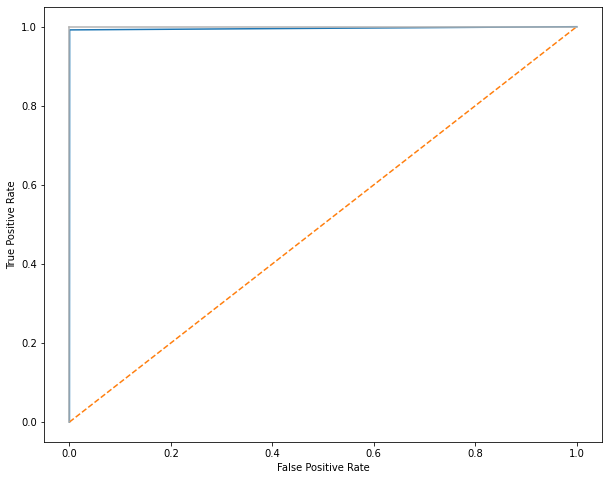

In [0]:
print(confusion_matrix(y_val,tree_pred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_val,tree_pred)))
print( )
print("Precision of the model is {} .".format(precision_score(y_val,tree_pred)))
print( )
print("Recall of the model is {} .".format(recall_score(y_val,tree_pred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_val,tree_pred)))
print( )
print("ROC_AUC of DecisionTree Classifier :")
fpr_tree,tpr_tree,thres_tree = roc_curve(y_val,tree_pred)
print("roc_auc_score is : ",roc_auc_score(y_val,tree_pred))
plt.figure(figsize=(10,8))
plt.plot(fpr_tree,tpr_tree)
plt.plot([0,1],ls="--")
plt.plot([0,0],[1,0],c="0.7")
plt.plot([1,1],c="0.7")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## XGBoost

In [0]:
xgb_model = XGBClassifier().fit(x_train,y_train)
xgbtrainpred = xgb_model.predict(x_train)
xgb_pred = xgb_model.predict(x_val)

Train accuracy

In [0]:
print(confusion_matrix(y_train,xgbtrainpred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_train,xgbtrainpred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_train,xgbtrainpred)))

[[631025      3]
 [   448  37738]]

accuracy of the model is 0.9993260750671683 .

F1_score of the model on train is 0.9940600840280795.


Validation accuracy

[[70169     0]
 [   61  4128]]

accuracy of the model is 0.999179644422927 .

Precision of the model is 1.0 .

Recall of the model is 0.9854380520410599 .

F1_score of the model on train is 0.9926656246242636.

ROC_AUC of XGBoost : 
roc_auc_score is :  0.99271902602053


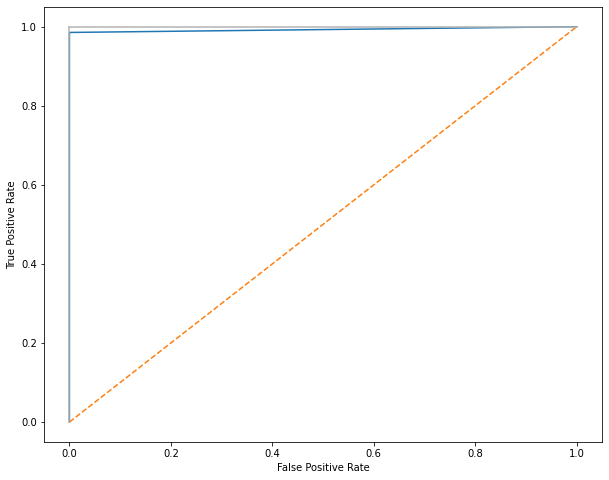

In [0]:
print(confusion_matrix(y_val,xgb_pred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_val,xgb_pred)))
print( )
print("Precision of the model is {} .".format(precision_score(y_val,xgb_pred)))
print( )
print("Recall of the model is {} .".format(recall_score(y_val,xgb_pred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_val,xgb_pred)))
print( )
print("ROC_AUC of XGBoost : ")
fpr_xgb,tpr_xgb,thres_xgb = roc_curve(y_val,xgb_pred)
print("roc_auc_score is : ",roc_auc_score(y_val,xgb_pred))
plt.figure(figsize=(10,8))
plt.plot(fpr_xgb,tpr_xgb)
plt.plot([0,1],ls="--")
plt.plot([0,0],[1,0],c="0.7")
plt.plot([1,1],c="0.7")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# KNN Classifier

In [0]:
knn_model = KNeighborsClassifier(n_neighbors=3).fit(x_train,y_train)
knntrainpred = knn_model.predict(x_train)
knn_pred = knn_model.predict(x_val)

Train accuracy

In [0]:
print(confusion_matrix(y_train,knntrainpred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_train,knntrainpred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_train,knntrainpred)))

[[630840    188]
 [  2207  35979]]

accuracy of the model is 0.9964211746915038 .

F1_score of the model on train is 0.967788791306336.


Validation accuracy

[[70123    46]
 [  343  3846]]

accuracy of the model is 0.9947685521396488 .

Precision of the model is 0.9881808838643371 .

Recall of the model is 0.9181188827882549 .

F1_score of the model on train is 0.9518623932681599.

ROC_AUC of KNN : 
roc_auc_score is :  0.9587316613203057


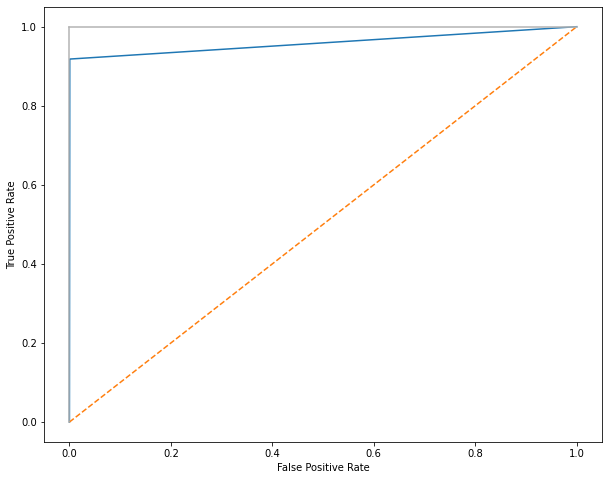

In [0]:
print(confusion_matrix(y_val,knn_pred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_val,knn_pred)))
print( )
print("Precision of the model is {} .".format(precision_score(y_val,knn_pred)))
print( )
print("Recall of the model is {} .".format(recall_score(y_val,knn_pred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_val,knn_pred)))
print( )
print("ROC_AUC of KNN : ")
fpr_knn,tpr_knn,thres_knn = roc_curve(y_val,knn_pred)
print("roc_auc_score is : ",roc_auc_score(y_val,knn_pred))
plt.figure(figsize=(10,8))
plt.plot(fpr_knn,tpr_knn)
plt.plot([0,1],ls="--")
plt.plot([0,0],[1,0],c="0.7")
plt.plot([1,1],c="0.7")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Using K-fold Cross Validation and then using grid search.

In [0]:
knn_cv = KNeighborsClassifier(n_neighbors=3)
 
cv_scores = cross_val_score(knn_cv, x_train,y_train, cv=5)

print(cv_scores)
print('cv_scores mean:{}'.format(np.mean(cv_scores)))

[0.99478493 0.99451596 0.99435159 0.99481482 0.99479237]
cv_scores mean:0.9946519351663772


### Using GridSearch

In [0]:
knn_model2 = KNeighborsClassifier()

param_grid = {'n_neighbors': np.arange(1, 25)}

knn_gscv = GridSearchCV(knn_model2, param_grid, cv=5)

knn_gscv.fit(x_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
knn_gscv.best_params_

{'n_neighbors': 3}

So,turns out our initial hyperparameter setup is what is best according to gridsearch

# SVM Classifier

In [0]:
svm_model = SVC().fit(x_train,y_train)
svmtrainpred = svm_model.predict(x_train)
svm_pred = svm_model.predict(x_val)

Train accuracy

In [0]:
print(confusion_matrix(y_train,svmtrainpred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_train,svmtrainpred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_train,svmtrainpred)))

[[630998     30]
 [  2983  35203]]

accuracy of the model is 0.9954977032757832 .

F1_score of the model on train is 0.9589615767035781.


Test accuracy

[[70165     4]
 [  337  3852]]

accuracy of the model is 0.9954140778396406 .

Precision of the model is 0.9989626556016598 .

Recall of the model is 0.9195512055383146 .

F1_score of the model on train is 0.9576134244872592.

ROC_AUC of SVM : 
roc_auc_score is :  0.9597471001540424


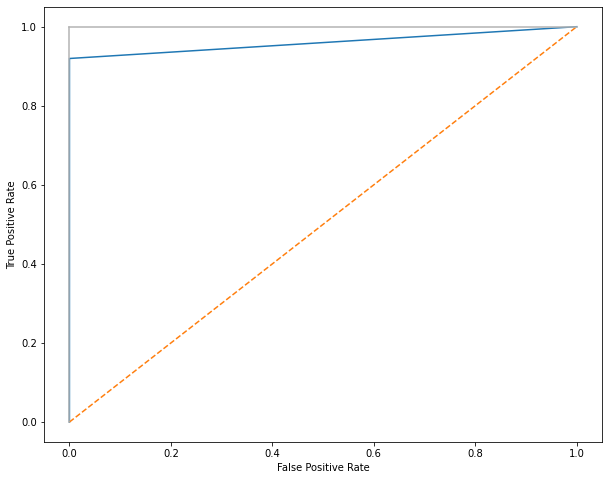

In [0]:
print(confusion_matrix(y_val,svm_pred))
print( )
print("accuracy of the model is {} .".format(accuracy_score(y_val,svm_pred)))
print( )
print("Precision of the model is {} .".format(precision_score(y_val,svm_pred)))
print( )
print("Recall of the model is {} .".format(recall_score(y_val,svm_pred)))
print( )
print("F1_score of the model on train is {}.".format(f1_score(y_val,svm_pred)))
print( )
print("ROC_AUC of SVM : ")
fpr_svm,tpr_svm,thres_svm = roc_curve(y_val,svm_pred)
print("roc_auc_score is : ",roc_auc_score(y_val,svm_pred))
plt.figure(figsize=(10,8))
plt.plot(fpr_svm,tpr_svm)
plt.plot([0,1],ls="--")
plt.plot([0,0],[1,0],c="0.7")
plt.plot([1,1],c="0.7")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Creating the test data(Taking rows for the month between june to december for the year of 2015) and removing columns from it.

In [0]:
test = data_enc[(data_enc['issue_year']==8) & (data_enc['issue_month']>5)]

For year 8 and for month greater than 5 is taken as what label encoder does is it labels categories from 0 to any value, on an ordinal way.
So we have a total of 9 years(2007-2015) so if we it assigns from 0 then 2015 will be assingned number 8 and so will happen for the the month. 

In [0]:
test.shape

(207744, 36)

## Prediction on test

In [0]:
x_sample = test.drop('default_ind',axis=1)
y_sample = test['default_ind']

In [0]:
Logsample = Log_model.predict(x_sample)
etrsample = etr_model.predict(x_sample)
rndsample = rnd_model.predict(x_sample)
treesample = tree_model.predict(x_sample)
xgbsample = xgb_model.predict(x_sample)
knnsample = knn_model.predict(x_sample)
svmsample = svm_model.predict(x_sample)

In [0]:
print("F1 score of Logistic Regression is {} .".format(f1_score(y_sample,Logsample)))
print("Precision of the model is {} .".format(precision_score(y_sample,Logsample)))
print("Recall of the model is {} .".format(recall_score(y_sample,Logsample)))
print("Accuracy of Model is {} .".format(accuracy_score(y_sample,Logsample)))
print("roc_auc_score is : ",roc_auc_score(y_sample,Logsample))
print()
print()
print("F1 score of ExtraTree Classifier is {} .".format(f1_score(y_sample,etrsample)))
print("Precision of the model is {} .".format(precision_score(y_sample,etrsample)))
print("Recall of the model is {} .".format(recall_score(y_sample,etrsample)))
print("Accuracy of Model is {} .".format(accuracy_score(y_sample,etrsample)))
print("roc_auc_score is : ",roc_auc_score(y_sample,etrsample))
print()
print()
print("F1 score of RandomForest Classifier is {} .".format(f1_score(y_sample,rndsample)))
print("Precision of the model is {} .".format(precision_score(y_sample,rndsample)))
print("Recall of the model is {} .".format(recall_score(y_sample,rndsample)))
print("Accuracy of Model is {} .".format(accuracy_score(y_sample,rndsample)))
print("roc_auc_score is : ",roc_auc_score(y_sample,rndsample))
print()
print()
print("F1 score of DecisionTree Classifier is {} .".format(f1_score(y_sample,treesample)))
print("Precision of the model is {} .".format(precision_score(y_sample,treesample)))
print("Recall of the model is {} .".format(recall_score(y_sample,treesample)))
print("Accuracy of Model is {} .".format(accuracy_score(y_sample,treesample)))
print("roc_auc_score is : ",roc_auc_score(y_sample,treesample))
print()
print()
print("F1 score of XGBoost is {} .".format(f1_score(y_sample,xgbsample)))
print("Precision of the model is {} .".format(precision_score(y_sample,xgbsample)))
print("Recall of the model is {} .".format(recall_score(y_sample,xgbsample)))
print("Accuracy of Model is {} .".format(accuracy_score(y_sample,xgbsample)))
print("roc_auc_score is : ",roc_auc_score(y_sample,xgbsample))
print()
print()
print("F1 score of KNN is {} .".format(f1_score(y_sample,knnsample)))
print("Precision of the model is {} .".format(precision_score(y_sample,knnsample)))
print("Recall of the model is {} .".format(recall_score(y_sample,knnsample)))
print("Accuracy of Model is {} .".format(accuracy_score(y_sample,knnsample)))
print("roc_auc_score is : ",roc_auc_score(y_sample,knnsample))
print()
print()
print("F1 score of SVM is {} .".format(f1_score(y_sample,svmsample)))
print("Precision of the model is {} .".format(precision_score(y_sample,svmsample)))
print("Recall of the model is {} .".format(recall_score(y_sample,svmsample)))
print("Accuracy of Model is {} .".format(accuracy_score(y_sample,svmsample)))
print("roc_auc_score is : ",roc_auc_score(y_sample,svmsample))

F1 score of Logistic Regression is 0.6019417475728155 .
Precision of the model is 0.5344827586206896 .
Recall of the model is 0.6888888888888889 .
Accuracy of Model is 0.9996052834257547 .
roc_auc_score is :  0.8443144204622433


F1 score of ExtraTree Classifier is 1.0 .
Precision of the model is 1.0 .
Recall of the model is 1.0 .
Accuracy of Model is 1.0 .
roc_auc_score is :  1.0


F1 score of RandomForest Classifier is 1.0 .
Precision of the model is 1.0 .
Recall of the model is 1.0 .
Accuracy of Model is 1.0 .
roc_auc_score is :  1.0


F1 score of DecisionTree Classifier is 0.9836065573770492 .
Precision of the model is 0.967741935483871 .
Recall of the model is 1.0 .
Accuracy of Model is 0.9999855591497228 .
roc_auc_score is :  0.9999927764454333


F1 score of XGBoost is 0.9944134078212291 .
Precision of the model is 1.0 .
Recall of the model is 0.9888888888888889 .
Accuracy of Model is 0.9999951863832409 .
roc_auc_score is :  0.9944444444444445


F1 score of KNN is 0.8026315789473

For the test data it turns out that Logistic Regression performs the worst,and the top performing models are ExtraTreeClassifier,RandomForestClassifier and XGBoost

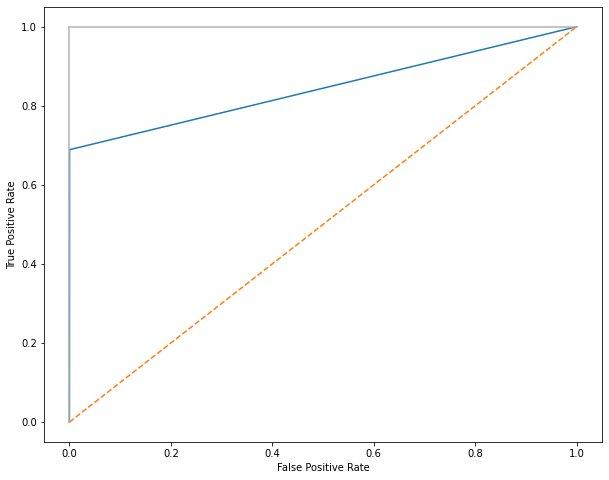

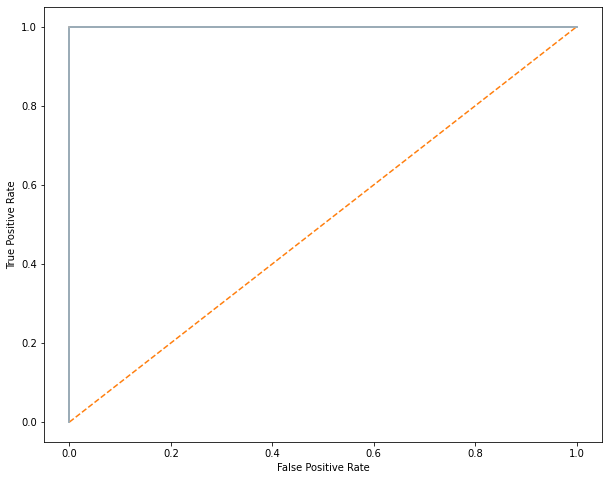

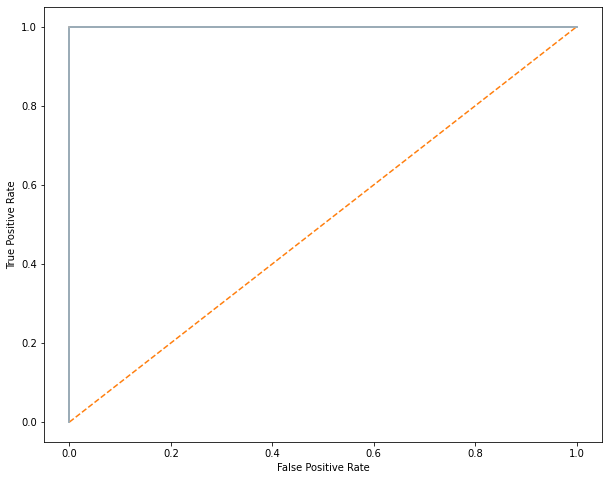

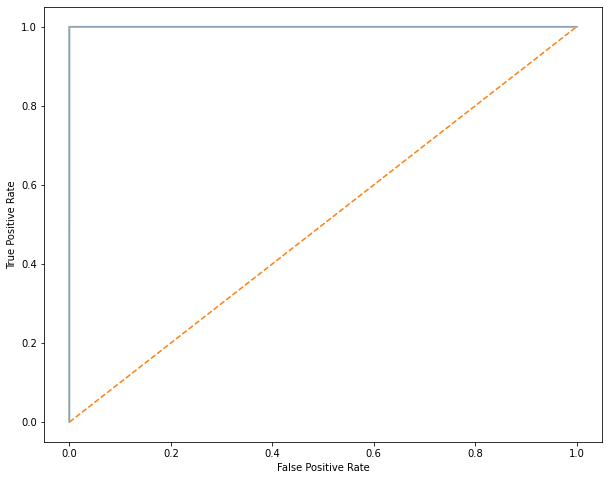

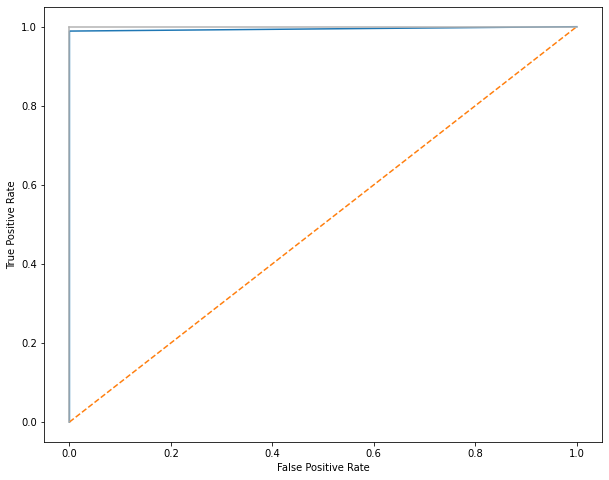

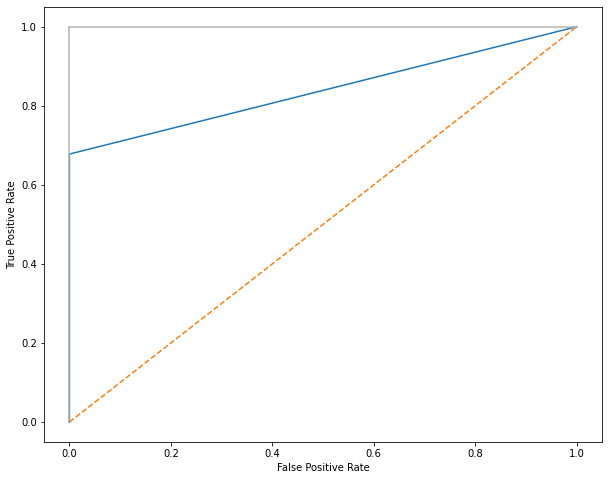

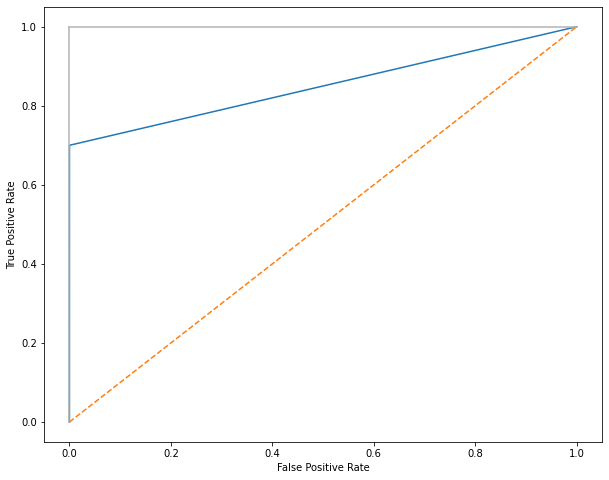

In [0]:
for i in [Logsample,etrsample,rndsample,treesample,xgbsample,knnsample,svmsample]:
  fpr,tpr,thres = roc_curve(y_sample,i)
  plt.figure(figsize=(10,8))
  plt.plot(fpr,tpr,label="{}, AUC={:.3f}")
  plt.plot([0,1],ls='--')
  plt.plot([0,0],[1,0],c="0.7")
  plt.plot([1,1],c="0.7")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()